# Setup Paths

In [95]:
import sys
import os

target_folder_name = "SymbolicDensityEstimation"
# 1. Get the current directory of the notebook.
current_dir = os.getcwd()

# # 2. Join it with '..' to get the parent directory.
parent_dir = os.path.join(current_dir, '..')

# # 3. change directory
current_folder_name = os.path.basename(current_dir)
is_match = current_folder_name == target_folder_name
if not is_match:
    os.chdir(parent_dir)

# # Get the current working directory as a string
current_directory = os.getcwd()

print("The current working directory is:")
print(current_directory)

The current working directory is:
/home/angel/WIP/Research/SymbolicDensityEstimation


# Imports

In [96]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from sklearn.neighbors import KernelDensity
import scipy
from scipy.stats import gaussian_kde
import pandas as pd
from tqdm import tqdm
from config_management.data_config_muon_decay import DataConfig
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
from matplotlib import cm  # For colormap
from KDEpy import FFTKDE
from scipy.stats import multivariate_normal
from scipy.interpolate import RegularGridInterpolator
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import gc
import dill
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.affinity import scale


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

In [97]:
file_path = './data/MuonDecay.csv'
df = pd.read_csv(file_path)
print(df.head())
columns = ['m13^2', 'm23^2']
samples = df[columns].to_numpy()
# Extract m13^2 and m23^2 columns
x1 = df['m13^2'] 
x2 = df['m23^2']

     # px_e      py_e      pz_e        e_e  px_vebar  py_vebar  pz_vebar  \
0 -0.024405 -0.955112  4.681573  70.162882  2.386838 -0.435416 -4.472082   
1  0.736816  4.934791 -5.654470  70.405029 -0.934946 -4.184292  4.924989   
2  2.188230  1.389730  2.652483  70.098184 -3.878535 -1.019773 -4.033545   
3  2.715311 -6.962994  0.573012  70.400174 -2.755233  5.900690 -0.419577   
4  2.924203  3.120980 -2.147847  70.163414 -3.880531 -3.897870  0.165664   

    e_vebar     px_vm     py_vm     pz_vm      e_vm        m12^2      m13^2  \
0  5.087839 -2.362433  1.390527 -0.209490  2.749280  5655.112355  38.590468   
1  6.529773  0.198129 -0.750499  0.729481  1.065198  5917.829131   0.815496   
2  5.687922  1.690305 -0.369957  1.381062  2.213894  5738.632458  48.683332   
3  6.525757  0.039921  1.062304 -0.153434  1.074069  5916.445213   1.572809   
4  5.502668  0.956328  0.776890  1.982183  2.333917  5719.908892  38.507340   

         m23^2  
0  5290.297178  
1  5065.355374  
2  5196.684210  


## Scatter Plot

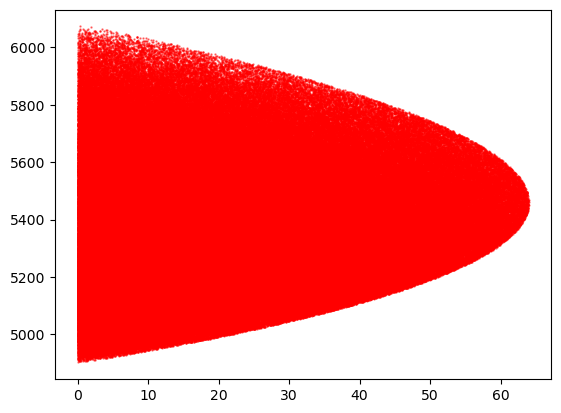

3211

In [98]:
plt.scatter(x1, x2, s=0.5, alpha=0.5, label='Data Points', color='red')
plt.show()
plt.close() 
gc.collect()

In [99]:
train_samples = np.loadtxt('data/processed_data/muon_decay_joint_data.csv', delimiter=',', skiprows=1)
test_samples = np.loadtxt('data/processed_data/muon_decay_test_samples.csv', delimiter=',', skiprows=1)
scaled_samples = np.concatenate([train_samples[:, 0:2], test_samples], axis=0)

hull = ConvexHull(scaled_samples)
hull_points = scaled_samples[hull.vertices]
polygon = Polygon(hull_points)
offset = 0.01
boundary_polygon = polygon.buffer(-offset, join_style=1)

x1 = train_samples[:,0]
x2 = train_samples[:,1]

if DataConfig.slices is None:
    xmin, xmax = x1.min()-DataConfig.grid_tolerance, x1.max()+DataConfig.grid_tolerance
    ymin, ymax = x2.min()-DataConfig.grid_tolerance, x2.max()+DataConfig.grid_tolerance
    grids = np.mgrid[xmin:xmax:DataConfig.jxbins, ymin:ymax:DataConfig.jxbins]
else:
    slices = DataConfig.slices
    grids = np.mgrid[tuple(slices)]

grid_coordinates = np.vstack([grids[0].ravel(), grids[1].ravel()])
grid_coordinates = grid_coordinates.T

In [100]:
np.max(train_samples[:,1])

0.9879609609609606

In [101]:
with open(f"models/muon_decay_kde_wrapped.pkl", "rb") as f:
    wrapper_model = dill.load(f)
kde_predicted_density = wrapper_model.evaluate(grid_coordinates).reshape(grids[0].shape)

In [102]:
import torch
import normflows as nf

with open(f"models/muon_decay_neural.pkl", "rb") as f:
    neural_model = dill.load(f)
param = next(neural_model.parameters())
grid_coordinates_tensor = torch.from_numpy(grid_coordinates).to(
    dtype=param.dtype,
    device=param.device
)
batch_size = 5000
neural_density_list = []
neural_model.eval()
with torch.no_grad():
    for batch_id, batch in enumerate(torch.split(grid_coordinates_tensor, batch_size)):
        neural_density_list.append(torch.exp(neural_model.log_prob(batch)))
        print(f"Percentage: {batch_id / len(torch.split(grid_coordinates_tensor, batch_size)) * 100} %")
neural_predicted_density = torch.cat(neural_density_list, dim=0).numpy()

neural_predicted_density = neural_predicted_density.reshape(grids[0].shape)

Percentage: 0.0 %
Percentage: 0.5 %
Percentage: 1.0 %
Percentage: 1.5 %
Percentage: 2.0 %
Percentage: 2.5 %
Percentage: 3.0 %
Percentage: 3.5000000000000004 %
Percentage: 4.0 %
Percentage: 4.5 %
Percentage: 5.0 %
Percentage: 5.5 %
Percentage: 6.0 %
Percentage: 6.5 %
Percentage: 7.000000000000001 %
Percentage: 7.5 %
Percentage: 8.0 %
Percentage: 8.5 %
Percentage: 9.0 %
Percentage: 9.5 %
Percentage: 10.0 %
Percentage: 10.5 %
Percentage: 11.0 %
Percentage: 11.5 %
Percentage: 12.0 %
Percentage: 12.5 %
Percentage: 13.0 %
Percentage: 13.5 %
Percentage: 14.000000000000002 %
Percentage: 14.499999999999998 %
Percentage: 15.0 %
Percentage: 15.5 %
Percentage: 16.0 %
Percentage: 16.5 %
Percentage: 17.0 %
Percentage: 17.5 %
Percentage: 18.0 %
Percentage: 18.5 %
Percentage: 19.0 %
Percentage: 19.5 %
Percentage: 20.0 %
Percentage: 20.5 %
Percentage: 21.0 %
Percentage: 21.5 %
Percentage: 22.0 %
Percentage: 22.5 %
Percentage: 23.0 %
Percentage: 23.5 %
Percentage: 24.0 %
Percentage: 24.5 %
Percentage: 2

## KDE Heatmap

In [103]:
xlims = (-0, 1)
ylims = (-0, 1)
color_level_min, color_level_max = 0.0, 5

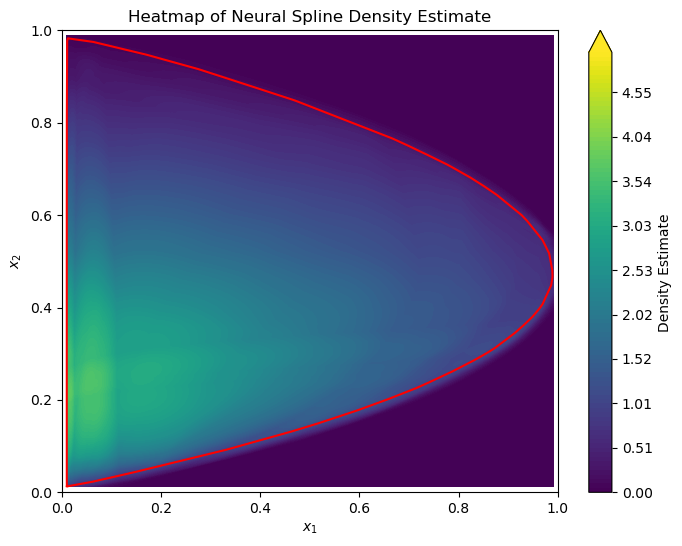

6361

In [104]:
levels = np.linspace(color_level_min, color_level_max, 100)  # for 30 intervals

plt.figure(figsize=(8, 6))
cf = plt.contourf(
    grids[0],
    grids[1],
    neural_predicted_density,
    levels=levels,
    cmap="viridis",
    extend="max"
)
cbar = plt.colorbar(cf, format="%.2f")
cbar.set_label("Density Estimate")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim(xlims)
plt.ylim(ylims)
plt.title("Heatmap of Neural Spline Density Estimate")
# plt.plot(*boundary_polygon.exterior.xy)
plt.plot(*boundary_polygon.exterior.xy, color='red')
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

In [105]:
density_scale_factor = np.loadtxt("data/processed_data/muon_decay_neural_scale_factor.txt")
print(f"scale factor: {density_scale_factor}")
print(f"max neural density: {np.max(neural_predicted_density)}, min neural density: {np.min(neural_predicted_density)}")
neural_predicted_density_scaled = neural_predicted_density * density_scale_factor
print(f"max scaled neural density: {np.max(neural_predicted_density_scaled)}, min scaled neural density: {np.min(neural_predicted_density_scaled)}")
data_in_pipeline = np.loadtxt('data/processed_data/muon_decay_neural_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
print(f"max data in pipeline: {np.max(data_in_pipeline[:,2])}, min data in pipeline: {np.min(data_in_pipeline[:,2])}")


scale factor: 2.65939136913981
max neural density: 3.774132490158081, min neural density: 3.7886737644994995e-15
max scaled neural density: 10.036895751953125, min scaled neural density: 1.0075566174840098e-14
max data in pipeline: 9.974489799304946, min data in pipeline: 0.09655147008133173


# Results

In [106]:
pow2 = lambda x: x ** 2
pow3 = lambda x: x ** 3
pow4 = lambda x: x ** 4
pow5 = lambda x: x ** 5

In [107]:
file_path = "data/pareto_results/muon_decay_neural_results.py"
exec(open(file_path).read())

Original at complexity 1: 4.009402833097119
function_ready: 4.009402833097119
Processed: 4.00000000000000
LaTeX: 4.0

Original at complexity 2: exp(1.3886262916750127)
function_ready: np.exp(1.3886262916750127)
Processed: 4.00000000000000
LaTeX: 4.0

Original at complexity 3: 4.502148428283847 - x2
function_ready: 4.502148428283847 - x2
Processed: 4.5 - x2
LaTeX: 4.5 - x_{2}

Original at complexity 4: pow3(2.050920839788502 - x2)
function_ready: pow3(2.050920839788502 - x2)
Processed: pow3(2.1 - x2)
LaTeX: 9.3 \left(1 - 0.48 x_{2}\right)^{3}

Original at complexity 5: pow3(1.8549604992460862 - pow2(x2))
function_ready: pow3(1.8549604992460862 - pow2(x2))
Processed: pow3(1.9 - pow2(x2))
LaTeX: 6.9 \left(1 - 0.53 x_{2}^{2}\right)^{3}

Original at complexity 6: pow2(x1 + (x2 + -2.8898579630253054))
function_ready: pow2(x1 + (x2 + -2.8898579630253054))
Processed: pow2(x1 + x2 - 2.9)
LaTeX: 8.4 \left(0.34 x_{1} + 0.34 x_{2} - 1\right)^{2}

Original at complexity 7: 8.533188941247719 - pow2(

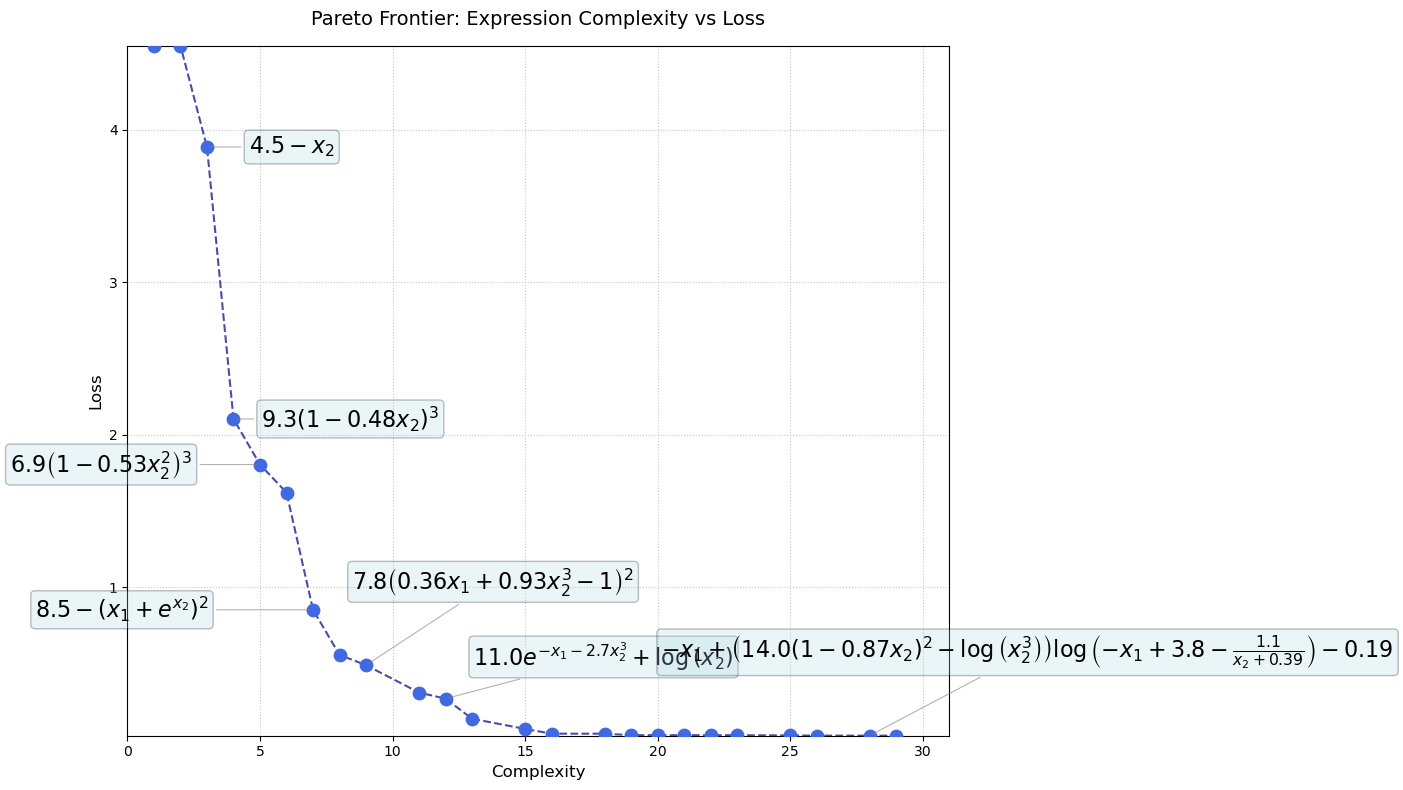

9467

In [108]:
range_of_interest = (1, 48)
indices_of_interest = [i for i, c in enumerate(complexity) if range_of_interest[0] <= c <= range_of_interest[1]]
complexity = [complexity[i] for i in indices_of_interest]
loss = [loss[i] for i in indices_of_interest]
raw_equations = [raw_equations[i] for i in indices_of_interest]

# 2) Sympy setup
x1, x2 = sp.symbols('x1 x2')

# 3) Custom function to round constants only (not function arguments)
def round_constants(expr, ndigits=1):
    """
    Round every bare Float in `expr` so that, when printed,
    it has exactly `ndigits` digits after the decimal point
    in scientific notation (i.e. nd+1 significant figures).
    """
    def _is_leaf_float(e):
        return e.is_Float and not e.args

    def _round_sci(e):
        f = float(e)
        # format with `ndigits` places after the decimal in the mantissa:
        sci_str = f"{f:.{ndigits}e}"
        return sp.Float(sci_str)

    return expr.replace(_is_leaf_float, _round_sci)

# 4) Function to convert pow2 to squared form without evaluation
def convert_pow2(expr):
    # Find all pow2 calls
    if expr.func.__name__ == 'pow2':
        return sp.Pow(convert_pow2(expr.args[0]), 2, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow2(arg) for arg in expr.args]) if expr.args else expr

def convert_pow3(expr):
    # Find all pow3 calls
    if expr.func.__name__ == 'pow3':
        return sp.Pow(convert_pow3(expr.args[0]), 3, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow3(arg) for arg in expr.args]) if expr.args else expr

def convert_pow4(expr):
    # Find all pow4 calls
    if expr.func.__name__ == 'pow4':
        return sp.Pow(convert_pow4(expr.args[0]), 4, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow4(arg) for arg in expr.args]) if expr.args else expr

def convert_pow5(expr):
    # Find all pow5 calls
    if expr.func.__name__ == 'pow5':
        return sp.Pow(convert_pow5(expr.args[0]), 5, evaluate=False)
    # Recurse through expression
    return expr.func(*[convert_pow5(arg) for arg in expr.args]) if expr.args else expr

# 4) Function to convert pow_int without evaluation
def convert_pow_int(expr):
    # Find all pow_int calls
    if expr.func.__name__ == 'pow_int':
        base, exp = expr.args
        # If exp is literally an integer, convert to a Python int
        if exp.is_integer and exp.is_number:
            exp = int(exp)
        # Otherwise leave exp symbolic
        return sp.Pow(convert_pow_int(base), convert_pow_int(exp), evaluate=False)

    # Recursively descend into all other function applications
    if expr.args:
        return expr.func(*[convert_pow_int(arg) for arg in expr.args])
    else:
        return expr
    
def replace_pow_functions_recursive(expr: sp.Expr) -> sp.Expr:
    """
    Recursively replaces custom functions like powN(x) with standard power notation x**N.
    E.g. pow3(x + pow2(y)) → (x + y**2)**3
    """
    # First, apply recursively to all arguments (bottom-up),
    # so that nested pow-functions inside arguments get replaced too.
    expr = expr.xreplace({})  # no-op; just ensures expr is a Basic (not strictly needed)

    # Define replacement function
    def _repl(f):
        # check it's a function call
        if not isinstance(f, sp.Function):
            return f

        name = f.func.__name__
        if not name.startswith("pow"):
            return f

        # parse N from “powN”
        try:
            N = int(name[len("pow"):])
        except ValueError:
            return f

        if len(f.args) != 1:
            # unexpected arity, leave unchanged
            return f

        base = f.args[0]
        # Recursively transform the base
        new_base = replace_pow_functions_recursive(base)
        return new_base ** N

    # Use replace with map=False (so it returns an Expr)
    new_expr = expr.replace(
        lambda x: isinstance(x, sp.Function) and x.func.__name__.startswith("pow"),
        _repl,
        map=False
    )
    return new_expr

# 5) Build MathText labels
latex_labels = []
exprs_final = []
function_ready = []
for id, s in enumerate(raw_equations):
    try:
        # Pre-process pow2 -> custom function
        s_processed = s.replace('pow2', 'pow2_func')
        s_processed = s.replace('pow3', 'pow3_func')
        s_processed = s.replace('pow4', 'pow4_func')
        s_processed = s.replace('pow5', 'pow5_func')
        s_processed = s_processed.replace('pow_int', 'pow_int_func')
        
        # Define custom functions
        locals_dict = {
            'x1': x1,
            'x2': x2,
            'pow2_func': sp.Function('pow2'),
            'pow3_func': sp.Function('pow3'),
            'pow4_func': sp.Function('pow4'),
            'pow5_func': sp.Function('pow5'),
            'pow_int_func': sp.Function('pow_int'),
            'asin': sp.asin,
            'atan': sp.atan,
            'tan': sp.tan,
            'exp': sp.exp,
        }
        
        # Parse while preserving structure
        expr = parse_expr(s_processed, evaluate=False, local_dict=locals_dict)
        
        # Convert pow2_func to squared form
        expr_converted_pow2 = convert_pow2(expr)
        expr_converted_pow3 = convert_pow3(expr)
        expr_converted_pow4 = convert_pow4(expr)
        expr_converted_pow5 = convert_pow5(expr)
        expr_converted = convert_pow_int(expr_converted_pow5)
        
        # Round constants (only standalone floats)
        expr_converted_int1 = round_constants(expr_converted)
        expr_converted_int2 = round_constants(expr_converted_int1)
        expr_final = round_constants(expr_converted_int2)
        # expr_final = expr_final.simplify()
        # expr_final = expr_final.expand()
        exprs_final.append(expr_final)

        # Get MathText-friendly LaTeX
        mt = replace_pow_functions_recursive(expr_final)
        expr_converted_int1 = round_constants(mt)
        expr_converted_int2 = round_constants(expr_converted_int1)
        mt = round_constants(expr_converted_int2)
        mt = sp.latex(mt)
        latex_labels.append(f"${mt}$")
        
        # Replace 'exp' with 'np.exp'
        modified_expression = s.replace('exp', 'np.exp')
    
        # Replace 'log' with 'np.log'
        modified_expression = modified_expression.replace('log', 'np.log')
        function_ready.append(modified_expression)
        # Debug print
        print(f"Original at complexity {complexity[id]}: {s}")
        print(f"function_ready: {modified_expression}")
        print(f"Processed: {expr_final}")
        print(f"LaTeX: {mt}\n")
    except Exception as e:
        print(f"Error processing expression: {s}\n{e}")
        latex_labels.append(f"Error: {s}")

# 6) Manual offsets for clarity
offsets = [
    (0, 0), (0, 0), (30, 0), (20, 0), (-180, 0),
    (-80, 0), (-200, 0), (0, 0), (-10, 60), (0, 0),
    (20, 30), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
    (0, 0), (0, 0), (-150, 60), (0, 0), (0, 0),
]

# 7) Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(complexity, loss, s=80, zorder=3, color='royalblue')
ax.plot(complexity, loss, linestyle='--', alpha=0.7, zorder=2, color='navy')

# Set axis limits
ax.set_xlim(min(complexity) - 1, max(complexity) + 2)
ax.set_ylim(min(loss) - 0.0005, max(loss))
fig.subplots_adjust(right=0.75)


skip_indices = []
keep_indices = [3-1, 4-1, 5-1, 7-1, 9-1, 11-1, 23-1]
# Annotate with MathText labels
for i, (x, y, lbl, (dx, dy)) in enumerate(zip(complexity, loss, latex_labels, offsets)):
    if i in skip_indices or (i not in keep_indices):
        continue
    ax.annotate(
        lbl,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords='offset points',
        ha='left',
        va='center',
        fontsize=16,
        bbox=dict(boxstyle='round,pad=0.2', alpha=0.25, fc='lightblue'),
        arrowprops=dict(arrowstyle='-', lw=0.8, alpha=0.6, color='gray')
    )

ax.set_title("Pareto Frontier: Expression Complexity vs Loss", fontsize=14, pad=15)
ax.set_xlabel("Complexity", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(True, linestyle=':', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

# Residuals: Prediction - Ground Truth

In [109]:
level_min = 0
level_max = 5
level_min_delta = -1
level_max_delta = 1

In [110]:
predicted_functions = [eval(f'lambda x1, x2: {str_func}', {'np':np, 'pow2':pow2, 'pow3':pow3, 'pow4':pow4, 'pow5':pow5}) for str_func in function_ready]
masked_functions = [
    (lambda f: lambda x1, x2, mask: np.where(mask, 0, f(x1, x2)))(f)
    for f in predicted_functions
]
mask = np.array([boundary_polygon.contains(Point(p)) for p in grid_coordinates]).reshape(np.shape(grids[0]))
mask = ~mask

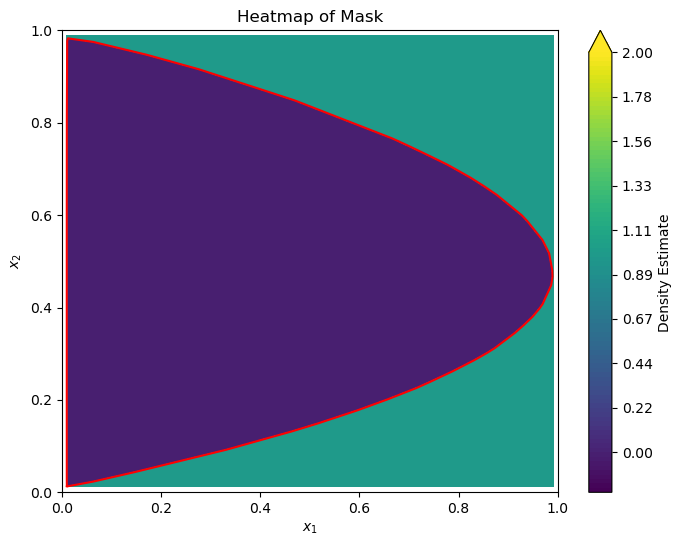

6470

In [111]:
levels = np.linspace(-0.2, 2, 100)  # for 30 intervals

plt.figure(figsize=(8, 6))
cf = plt.contourf(
    grids[0],
    grids[1],
    mask,
    levels=levels,
    cmap="viridis",
    extend="max"
)
cbar = plt.colorbar(cf, format="%.2f")
cbar.set_label("Density Estimate")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim(xlims)
plt.ylim(ylims)
plt.title("Heatmap of Mask")
# plt.plot(*boundary_polygon.exterior.xy)
plt.plot(*boundary_polygon.exterior.xy, color='red')
plt.show()
# Explicitly close the figure object
plt.close() 
# Force the Python garbage collector to clean up memory
gc.collect()

In [112]:
# 2. Interpolate the reflected function at the original grid points
# Prepare the interpolator for the original function
interp_kde_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    kde_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)

interp_neural_at_samples = RegularGridInterpolator(
    (grids[0][:,0], grids[1][0,:]),  # axes of the grid
    neural_predicted_density,            # function values
    bounds_error=False,
    fill_value=0
)

# Load the test set for the Gaussian mixture
test_samples = np.loadtxt("./data/processed_data/muon_decay_test_samples.csv", delimiter=",")
test_samples = test_samples[test_samples[:,0]>0.01]
test_samples = test_samples[test_samples[:,0]<0.99]
test_samples = test_samples[test_samples[:,1]>0.01]
test_samples = test_samples[test_samples[:,1]<0.99]

# For each original grid point, get the value of the reflected functions at that location
kde_eval_at_samples = interp_kde_at_samples(test_samples)
neural_eval_at_samples = interp_neural_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples+1e-12))
likelihood_score_neural = np.sum(np.log(neural_eval_at_samples))
print(f"Likelihood score of the corrected KDE: {likelihood_score:,}")
print(f"Likelihood score of the neural spline: {likelihood_score_neural:,}")

Likelihood score of the corrected KDE: 26,762.04133809931
Likelihood score of the neural spline: 27,093.2315196422


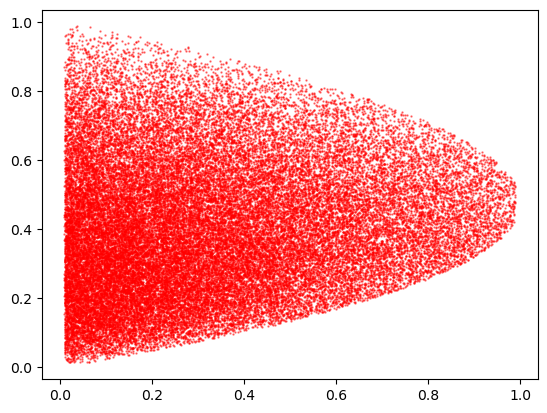

3117

In [113]:
plt.scatter(test_samples[:,0], test_samples[:,1], s=0.5, alpha=0.5, label='Data Points', color='red')
plt.show()
plt.close() 
gc.collect()

Likelihood score of the KDE: 26,762.04133806572

Likelihood score of the neural spline: 27,093.2315196422

Function at complexity 1: Likelihood score = 0.4105450227835186
Function at complexity 2: Likelihood score = 0.41052900365680467
Function at complexity 3: Likelihood score = 21,037.098603952094
Function at complexity 4: Likelihood score = 24,006.335521140758
Function at complexity 5: Likelihood score = 24,989.08999257395
Function at complexity 6: Likelihood score = 25,686.49762065329
Function at complexity 7: Likelihood score = 26,327.975856135214
Function at complexity 8: Likelihood score = 27,707.51034296136
Function at complexity 9: Likelihood score = 26,947.18431324831
Function at complexity 11: Likelihood score = 27,360.95263003336
Function at complexity 12: Likelihood score = 27,132.4397913656
Function at complexity 13: Likelihood score = nan
Function at complexity 15: Likelihood score = nan
Function at complexity 16: Likelihood score = 27,325.864049848755
Function at comple

/tmp/ipykernel_169391/2696772407.py:13: RuntimeWarning:

invalid value encountered in log



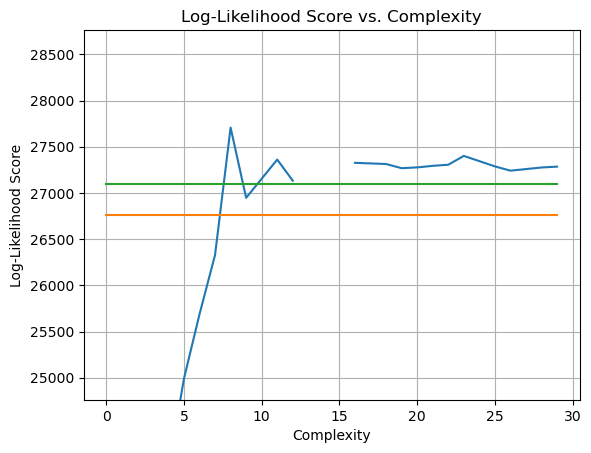

In [127]:
kde_eval_at_samples = interp_kde_at_samples(test_samples)
neural_eval_at_samples = interp_neural_at_samples(test_samples)
likelihood_score = np.sum(np.log(kde_eval_at_samples+1e-130))
likelihood_score_neural = np.sum(np.log(neural_eval_at_samples+1e-130))

print(f"Likelihood score of the KDE: {likelihood_score:,}\n")
print(f"Likelihood score of the neural spline: {likelihood_score_neural:,}\n")

log_likelihood_scores = []
for idx, func in enumerate(predicted_functions):
    # Compute likelihood scores
    prediction_eval_at_samples = func(test_samples[:, 0], test_samples[:, 1])
    likelihood_score_pred = np.sum(np.log(prediction_eval_at_samples/density_scale_factor + 1e-12))  # add small value to avoid log(0)
    log_likelihood_scores.append(likelihood_score_pred)
    print(f"Function at complexity {complexity[idx]}: Likelihood score = {likelihood_score_pred:,}")

plt.plot(complexity, log_likelihood_scores, label="Predicted Functions")
plt.plot([0, max(complexity)], [likelihood_score, likelihood_score], label="KDE")
plt.plot([0, max(complexity)], [likelihood_score_neural, likelihood_score_neural], label="Neural Spline")
plt.xlabel("Complexity")
plt.ylabel("Log-Likelihood Score")
plt.title("Log-Likelihood Score vs. Complexity")
plt.ylim([likelihood_score-2000, likelihood_score+2000])
plt.grid(True)
plt.show()

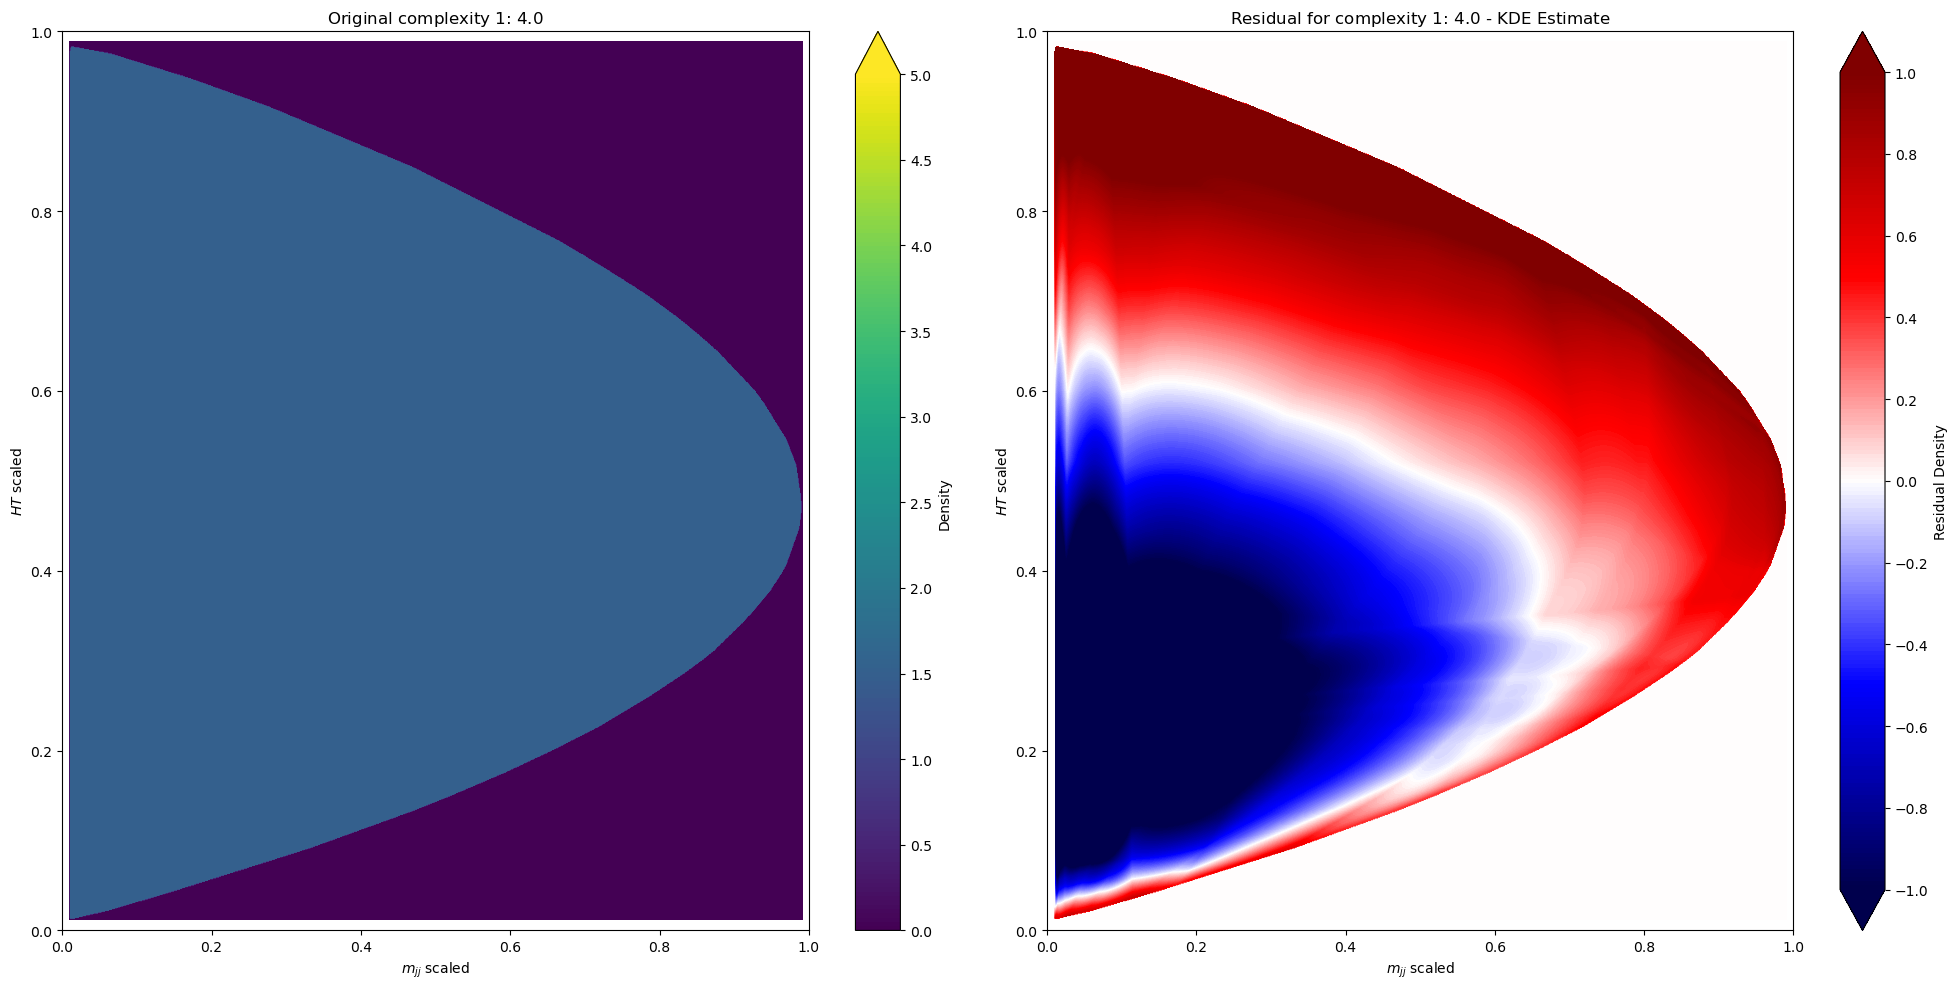

Complexity 1: Likelihood score: 20,062.924718375358
complexity 1 :: min predict: 0.00, max predict: 1.51
complexity 1 :: min residual: -2.27, max residual: 1.48
Complexity 1: MSE error: 3.049802e+00


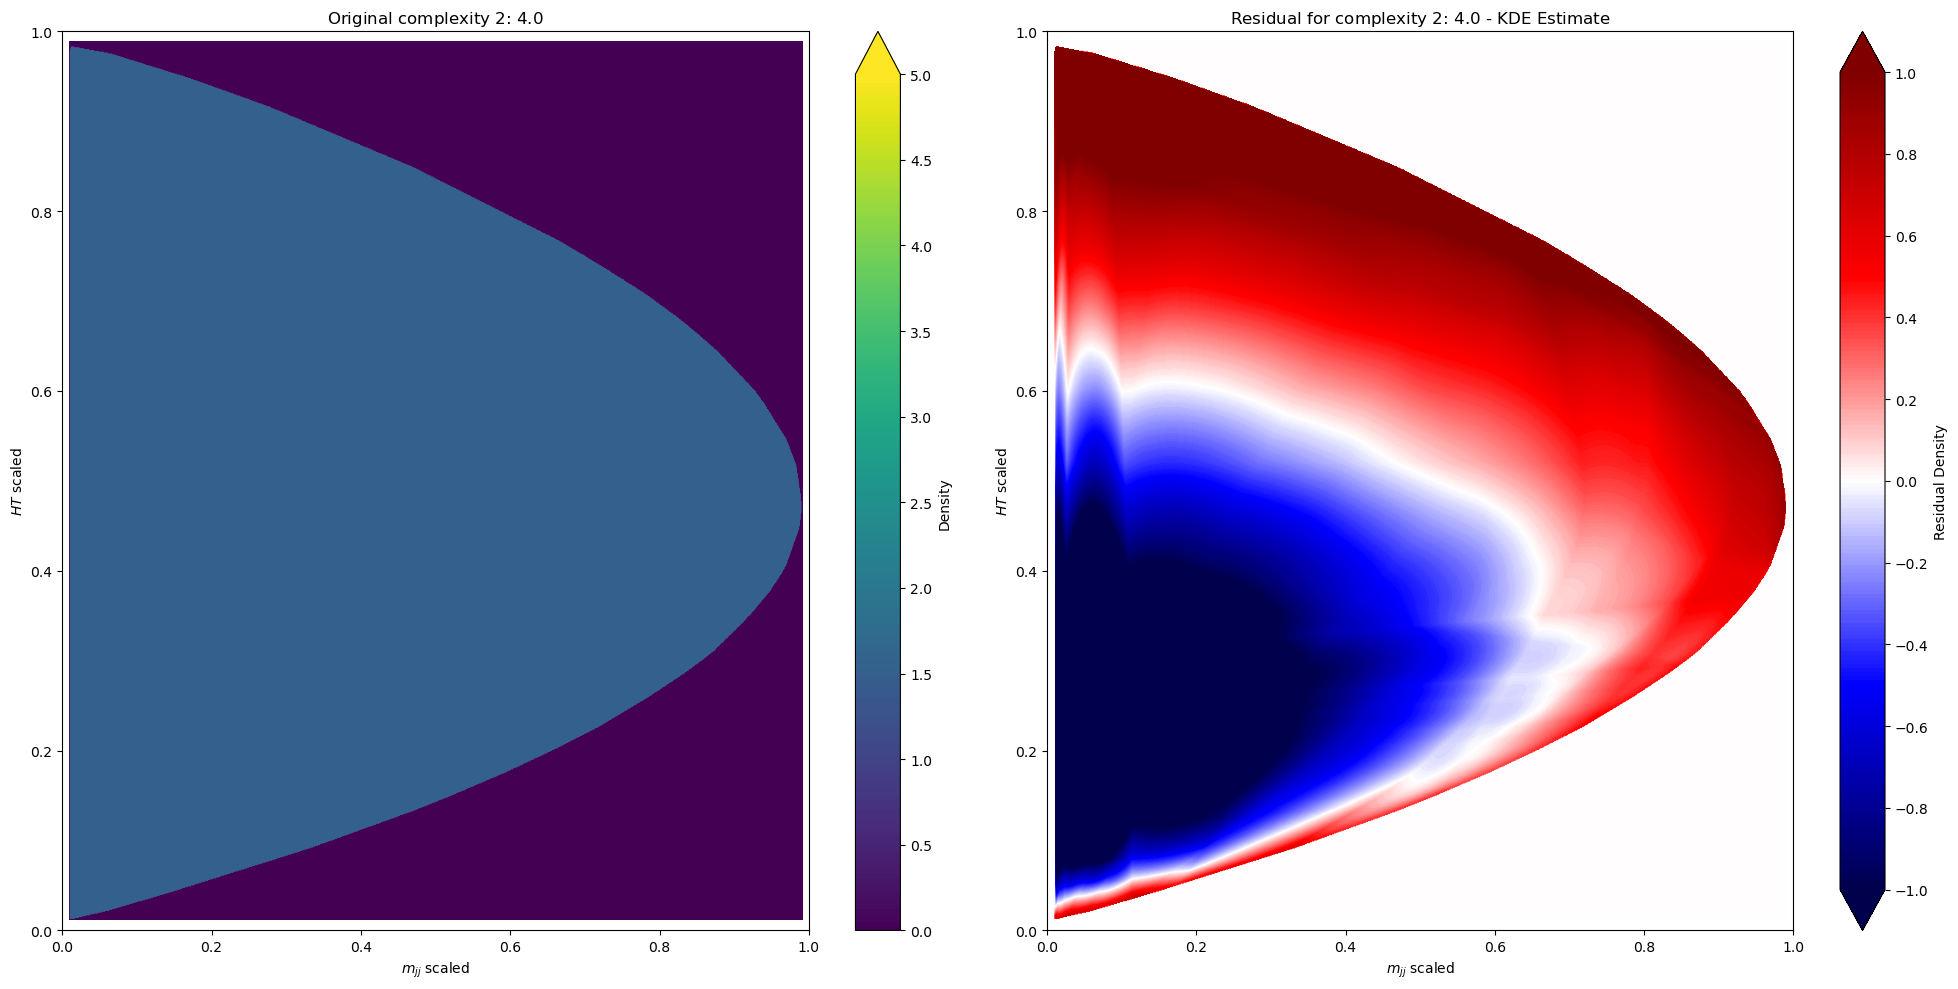

Complexity 2: Likelihood score: 20,062.141879671977
complexity 2 :: min predict: 0.00, max predict: 1.51
complexity 2 :: min residual: -2.27, max residual: 1.48
Complexity 2: MSE error: 3.049804e+00


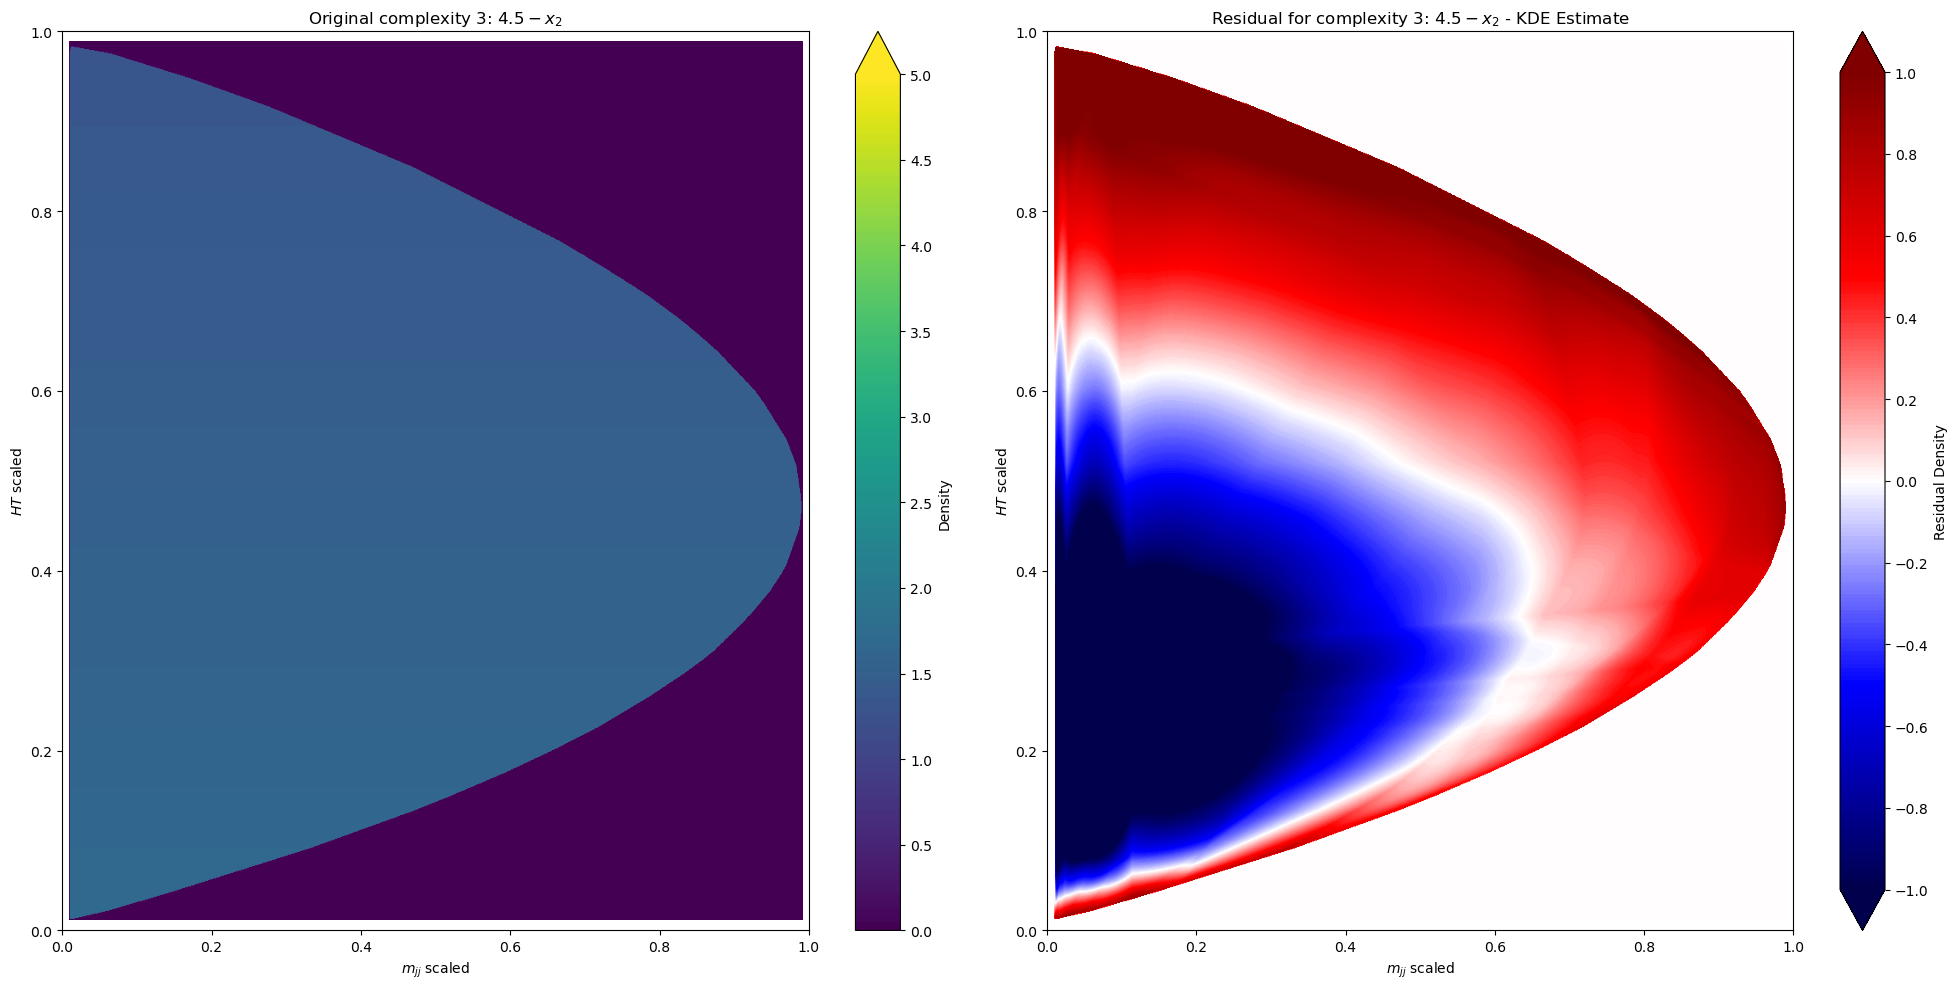

Complexity 3: Likelihood score: 21,037.09860392028
complexity 3 :: min predict: 0.00, max predict: 1.69
complexity 3 :: min residual: -2.16, max residual: 1.30
Complexity 3: MSE error: 2.606402e+00


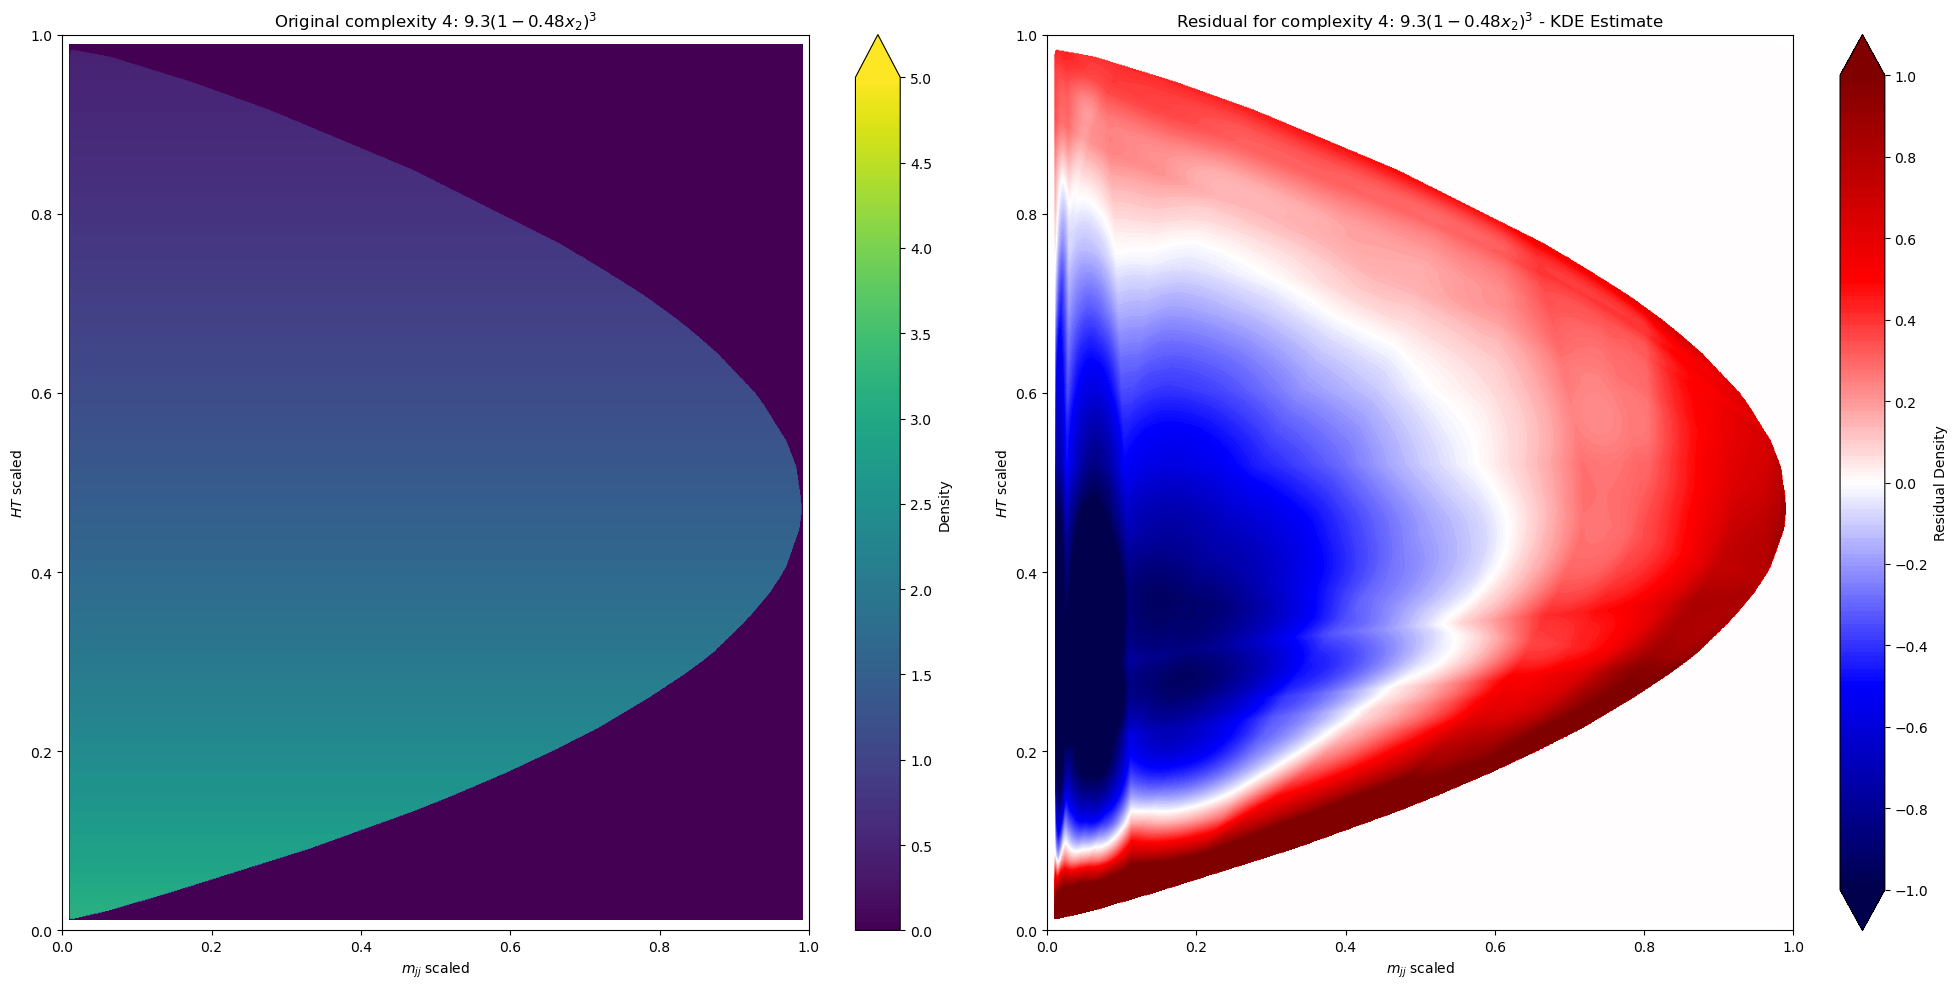

Complexity 4: Likelihood score: 24,006.335521108736
complexity 4 :: min predict: 0.00, max predict: 3.18
complexity 4 :: min residual: -1.49, max residual: 2.36
Complexity 4: MSE error: 1.416302e+00


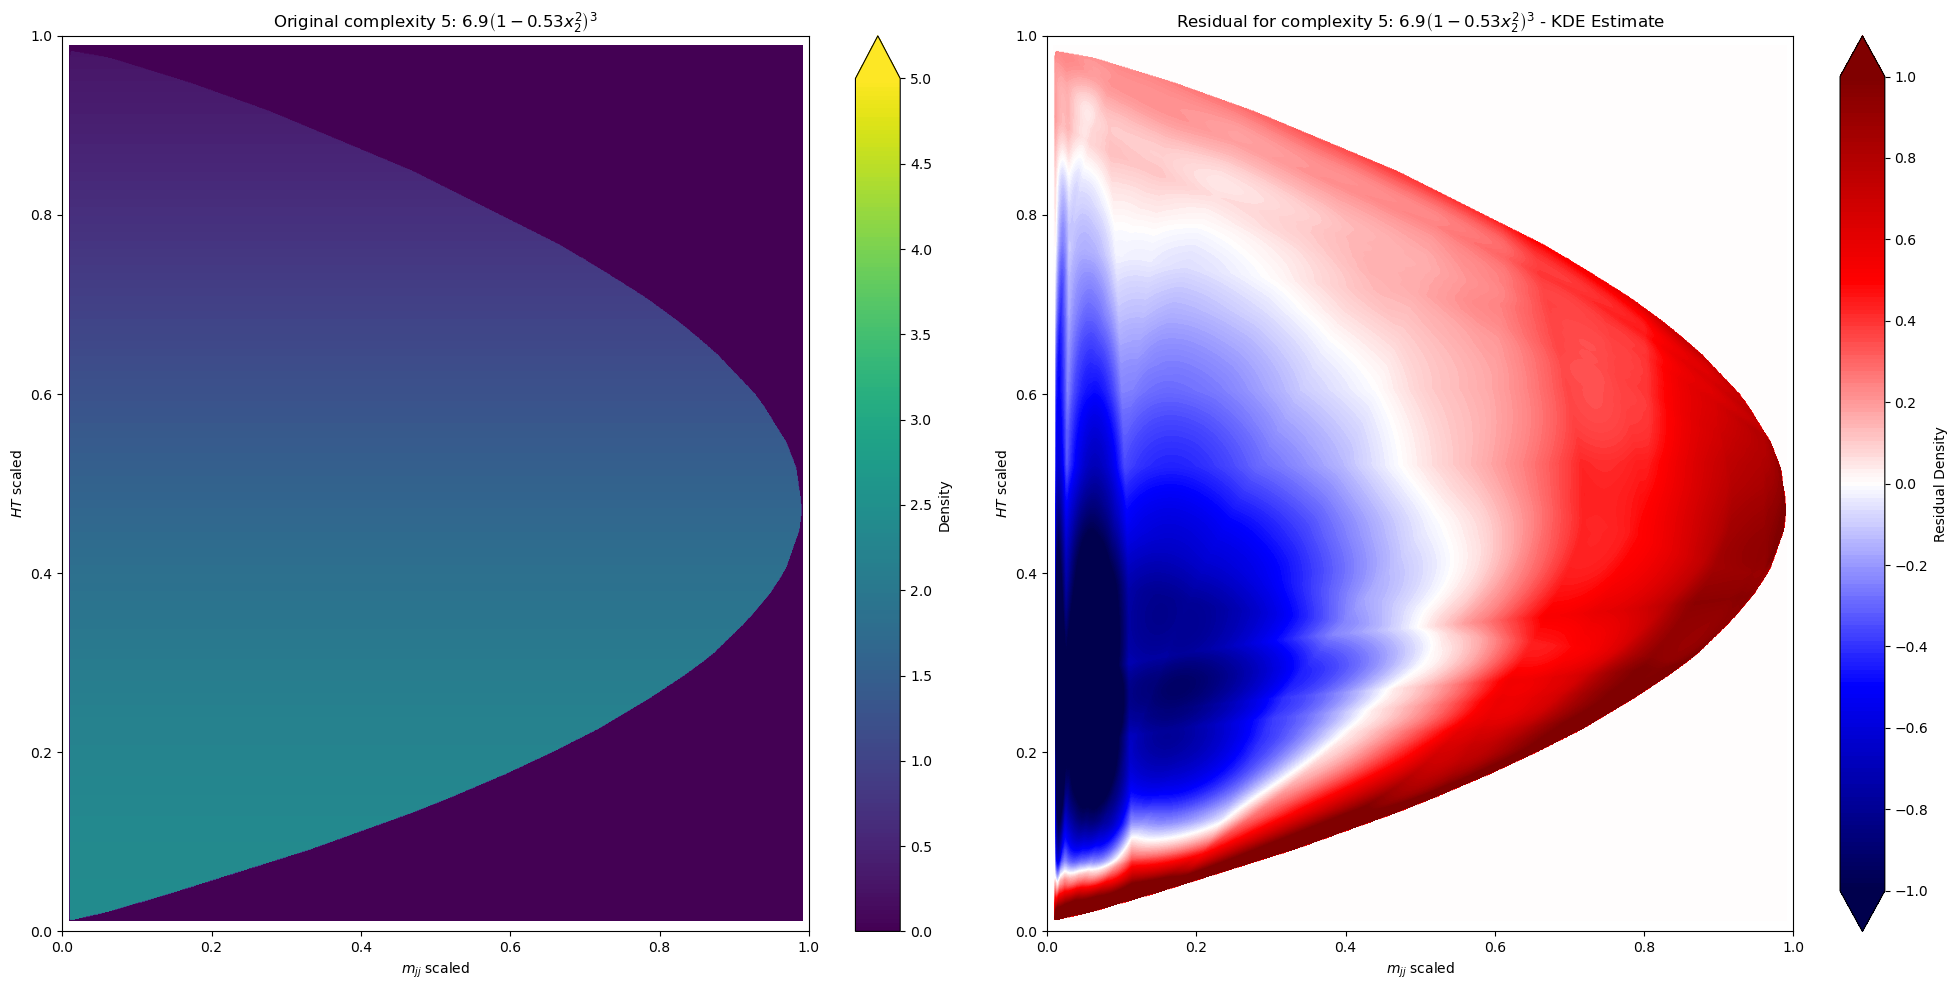

Complexity 5: Likelihood score: 24,989.089992542562
complexity 5 :: min predict: 0.00, max predict: 2.40
complexity 5 :: min residual: -1.55, max residual: 1.62
Complexity 5: MSE error: 1.211030e+00


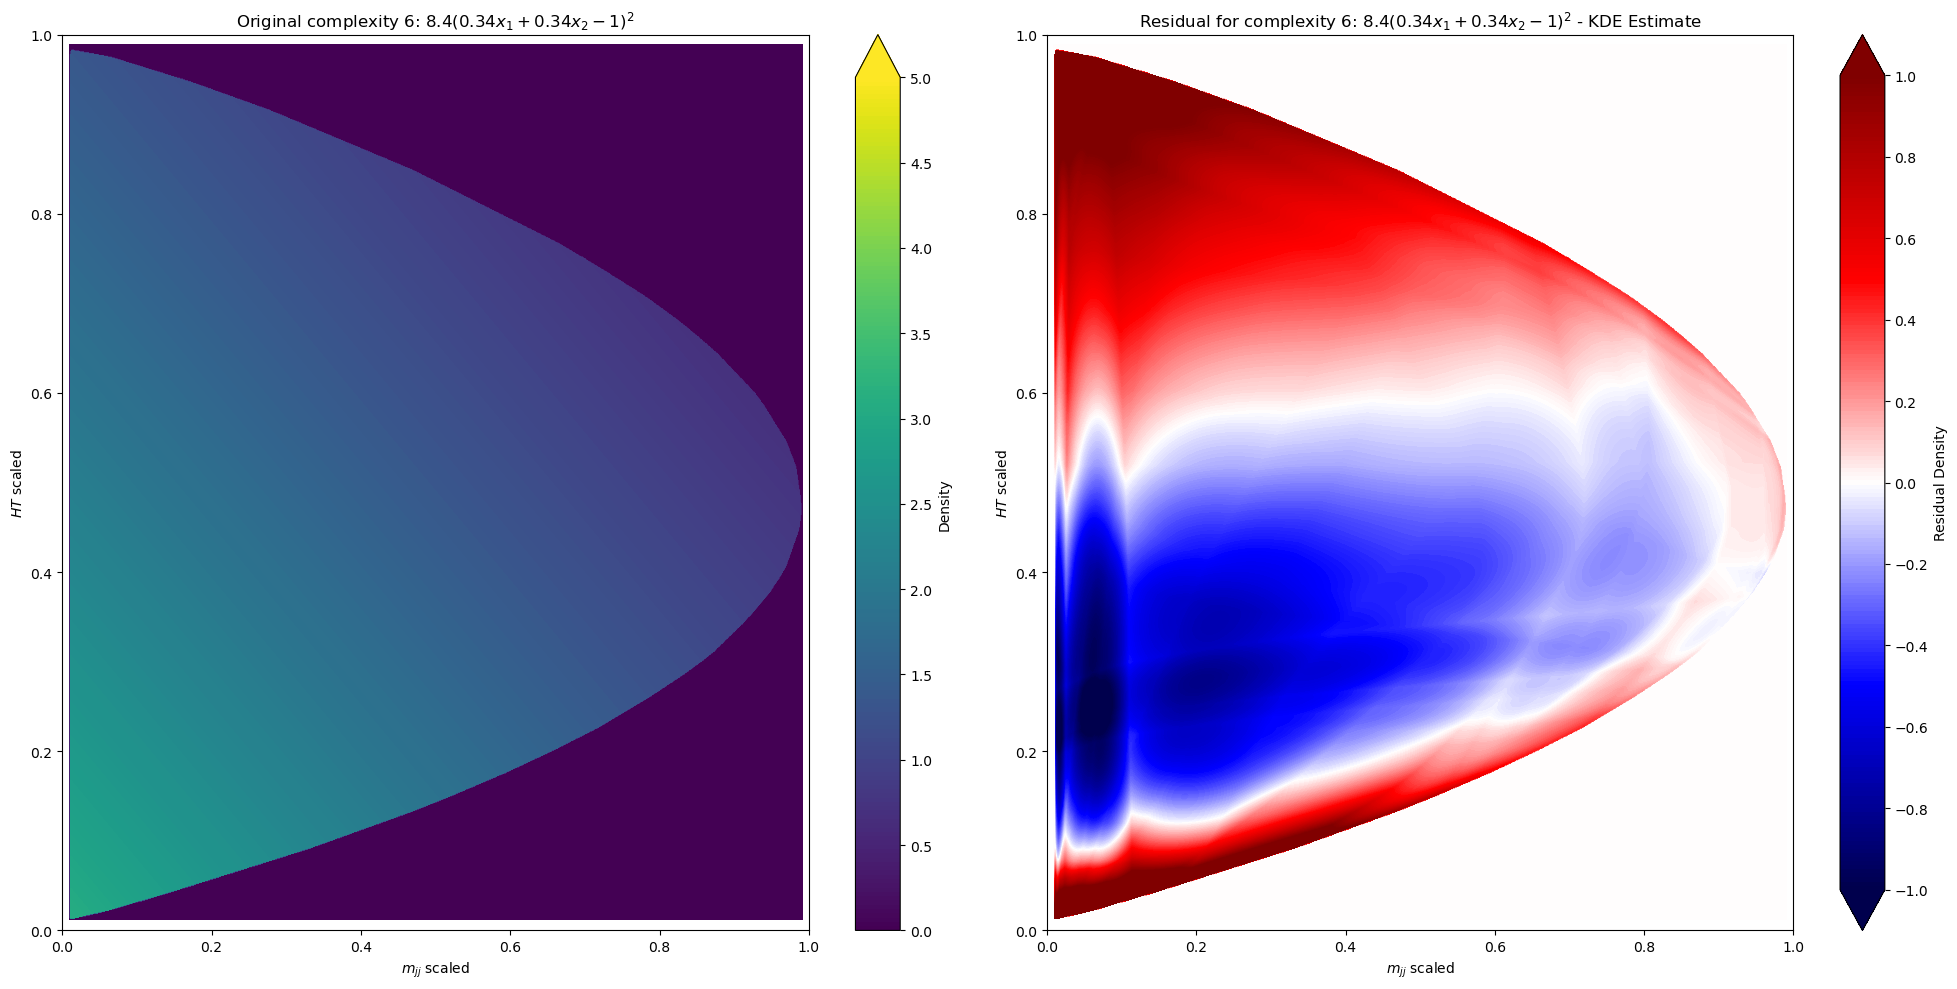

Complexity 6: Likelihood score: 25,686.49762062287
complexity 6 :: min predict: 0.00, max predict: 3.09
complexity 6 :: min residual: -1.11, max residual: 2.24
Complexity 6: MSE error: 1.096411e+00


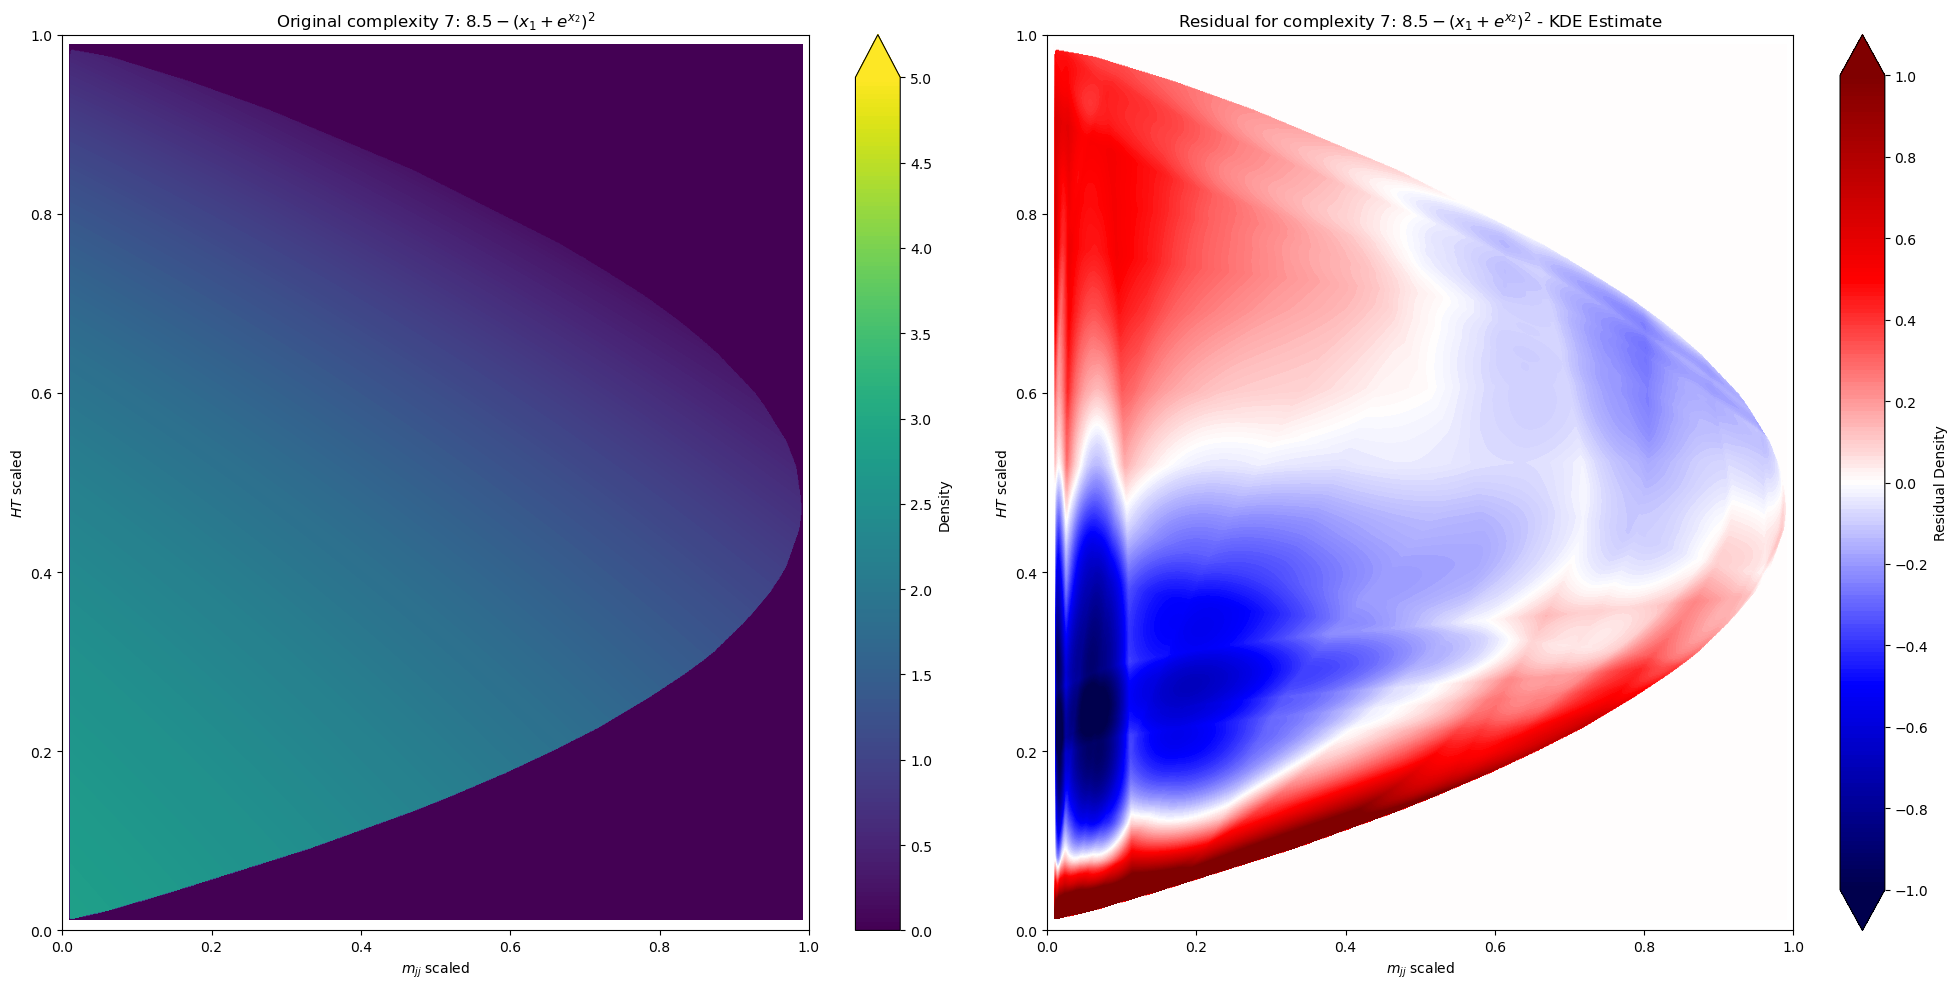

Complexity 7: Likelihood score: 26,327.975856103396
complexity 7 :: min predict: 0.00, max predict: 2.81
complexity 7 :: min residual: -1.16, max residual: 2.00
Complexity 7: MSE error: 5.786402e-01


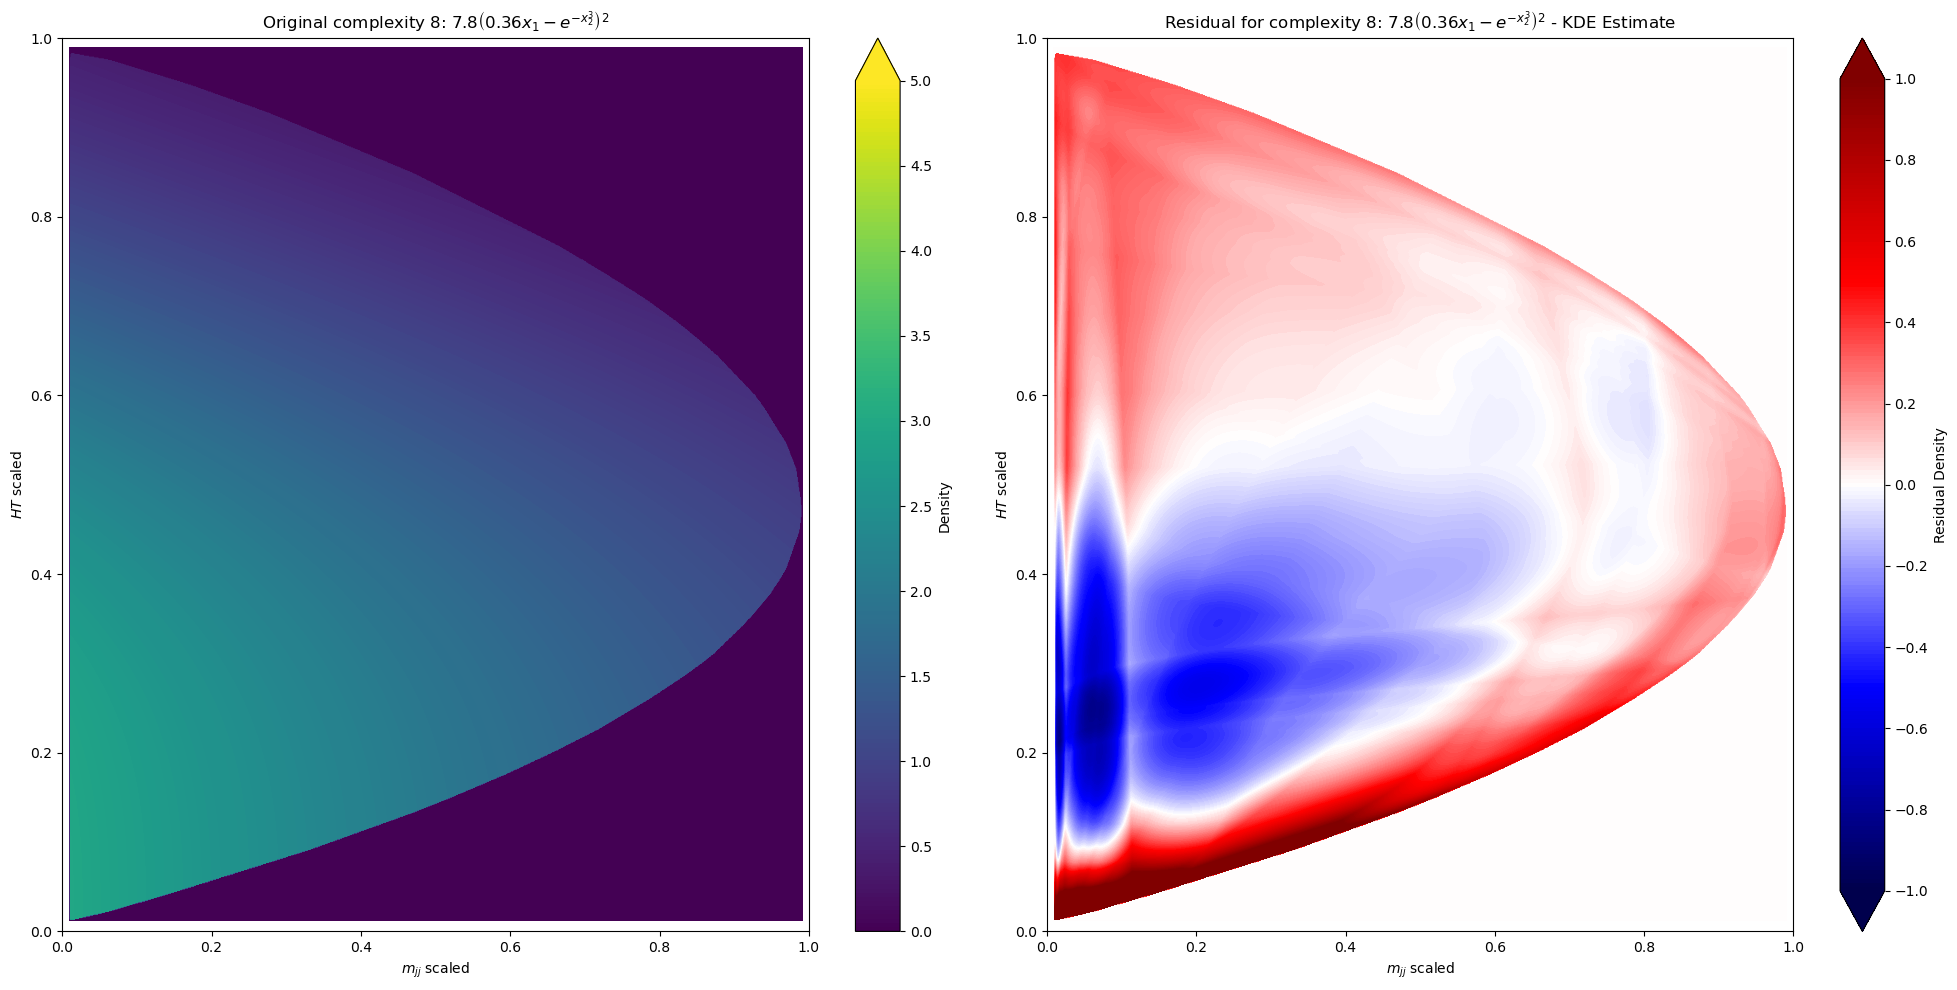

Complexity 8: Likelihood score: 27,707.510342931055
complexity 8 :: min predict: 0.00, max predict: 2.97
complexity 8 :: min residual: -0.87, max residual: 2.14
Complexity 8: MSE error: 3.795916e-01


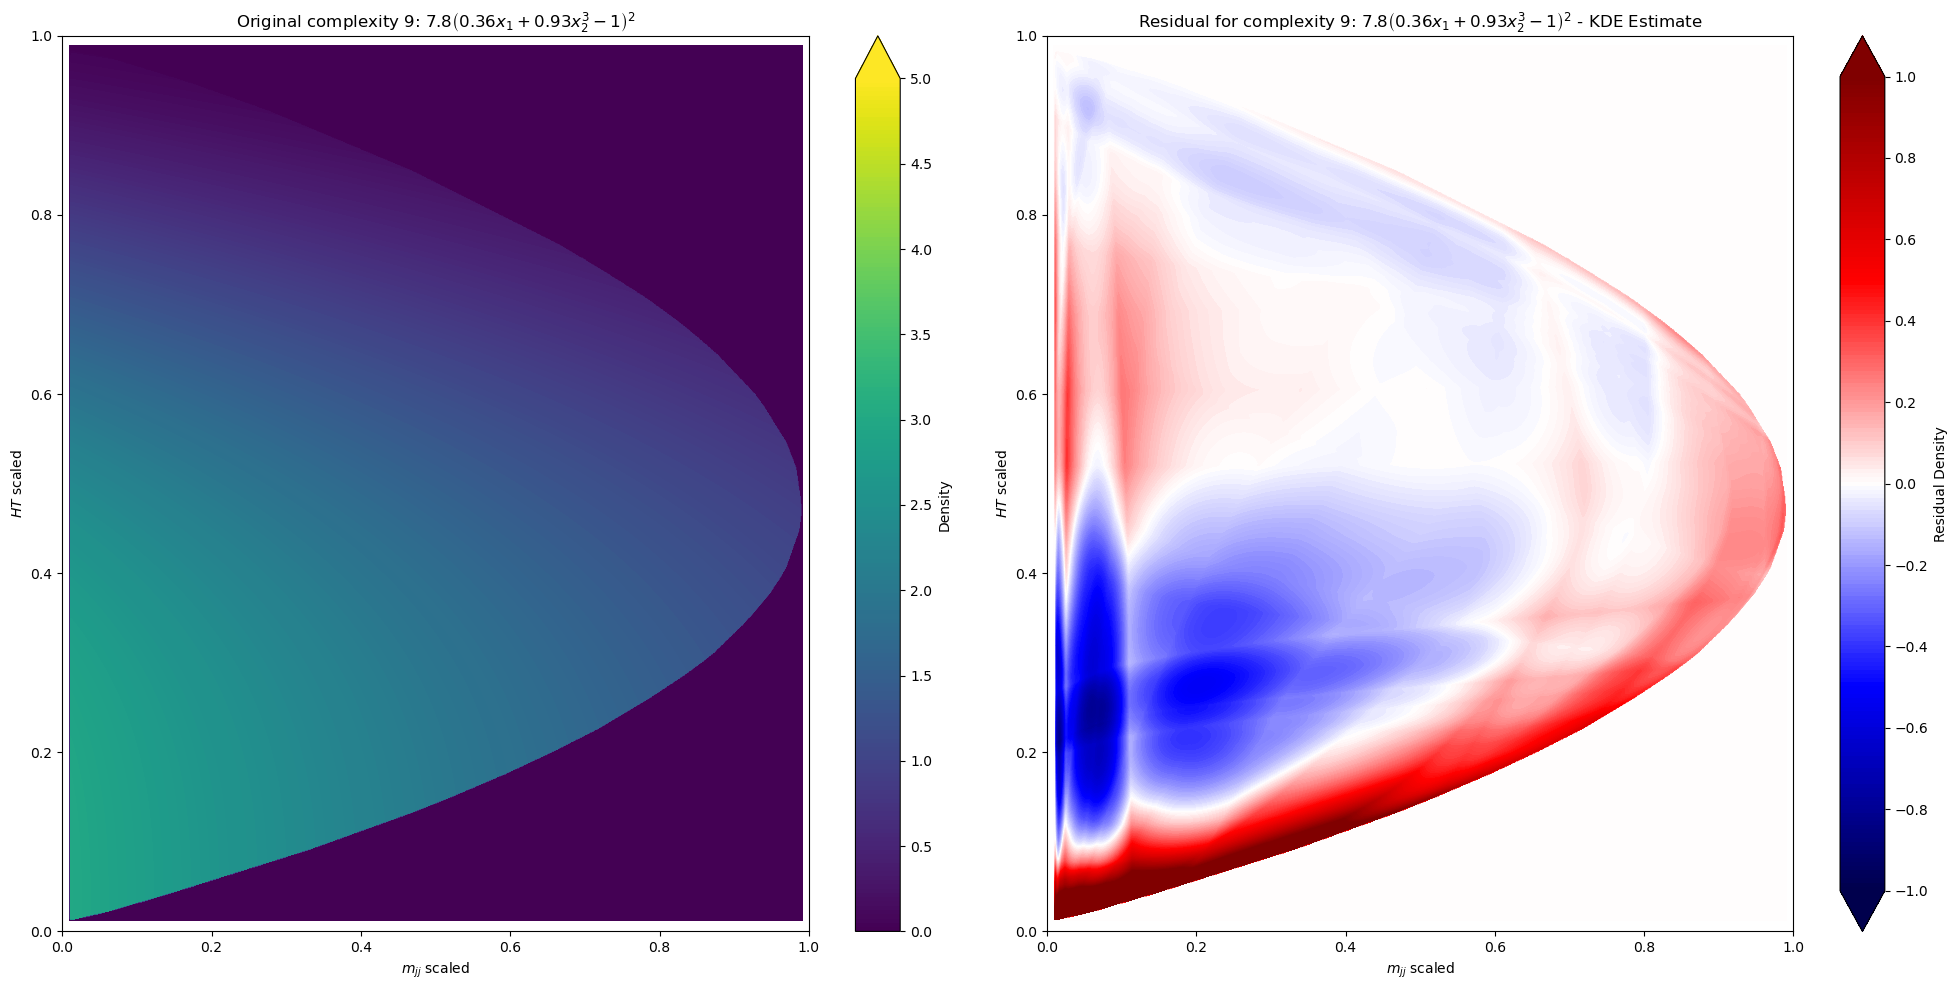

Complexity 9: Likelihood score: 26,947.18431321542
complexity 9 :: min predict: 0.00, max predict: 3.00
complexity 9 :: min residual: -0.84, max residual: 2.16
Complexity 9: MSE error: 3.343764e-01


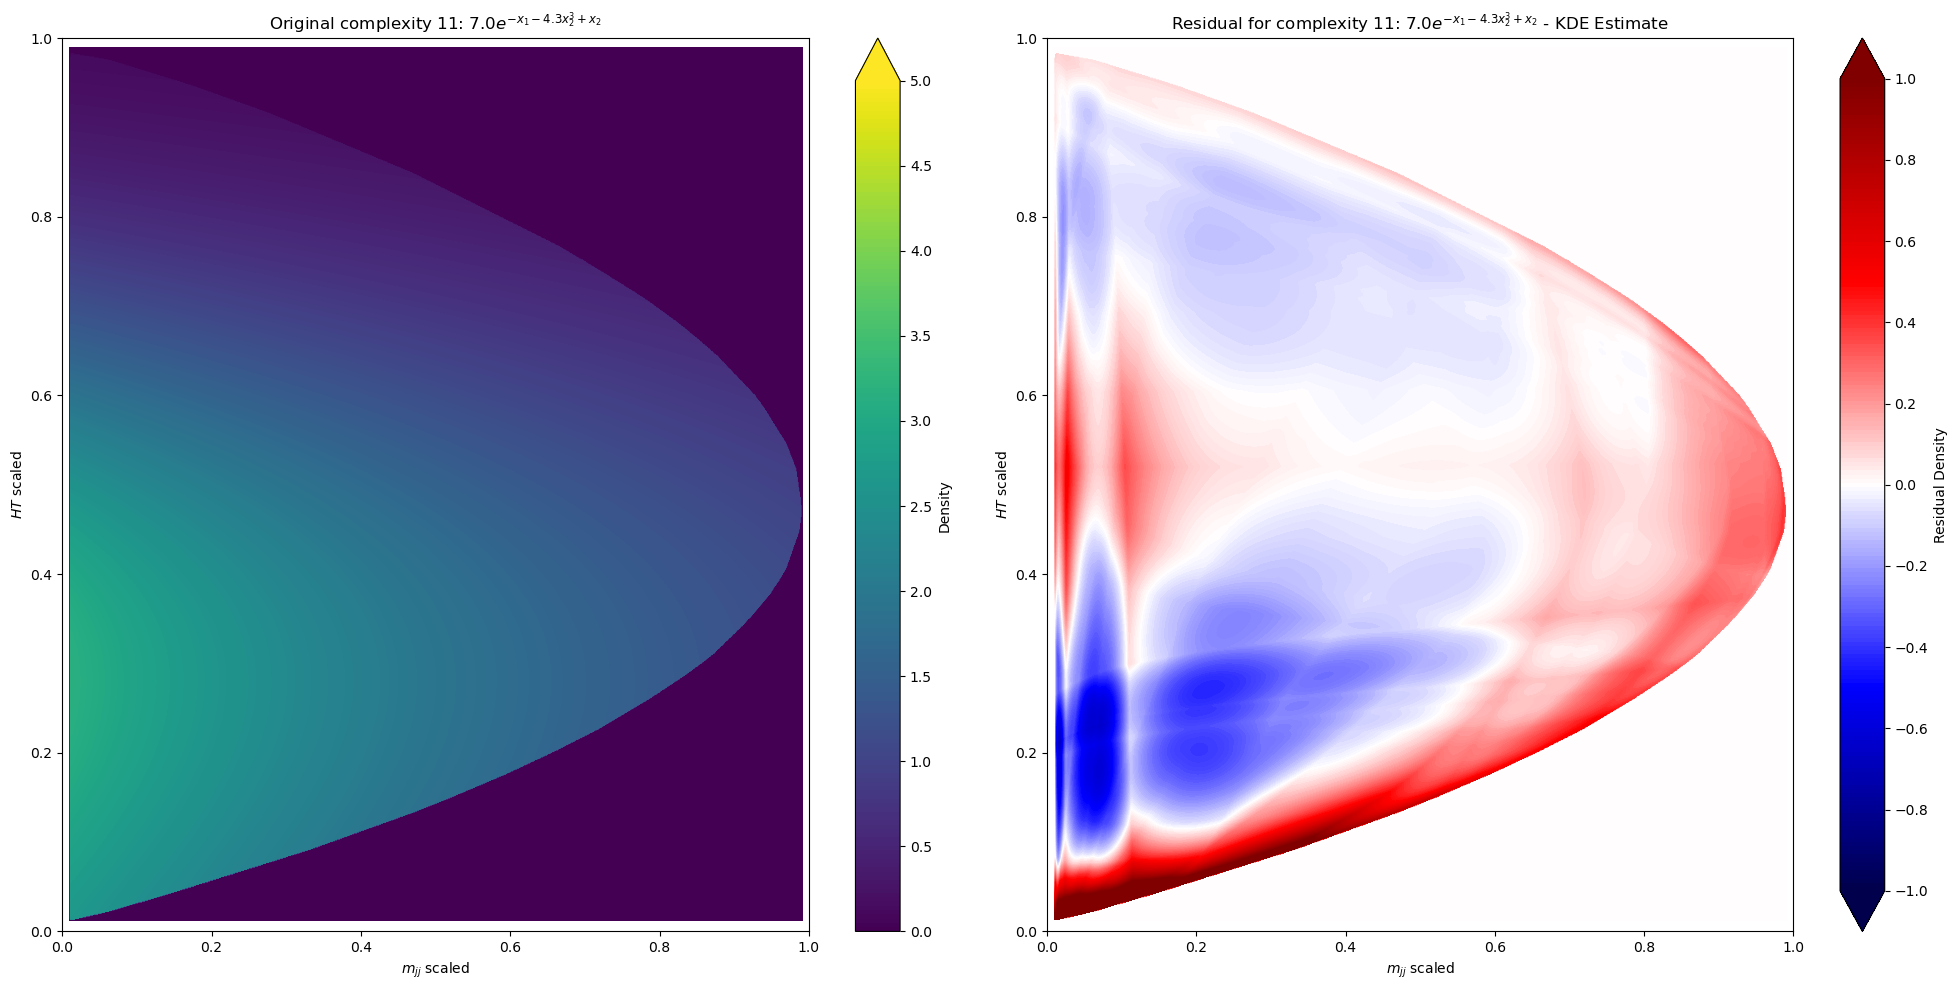

Complexity 11: Likelihood score: 27,360.95263000099
complexity 11 :: min predict: 0.00, max predict: 3.16
complexity 11 :: min residual: -0.68, max residual: 1.82
Complexity 11: MSE error: 2.134685e-01


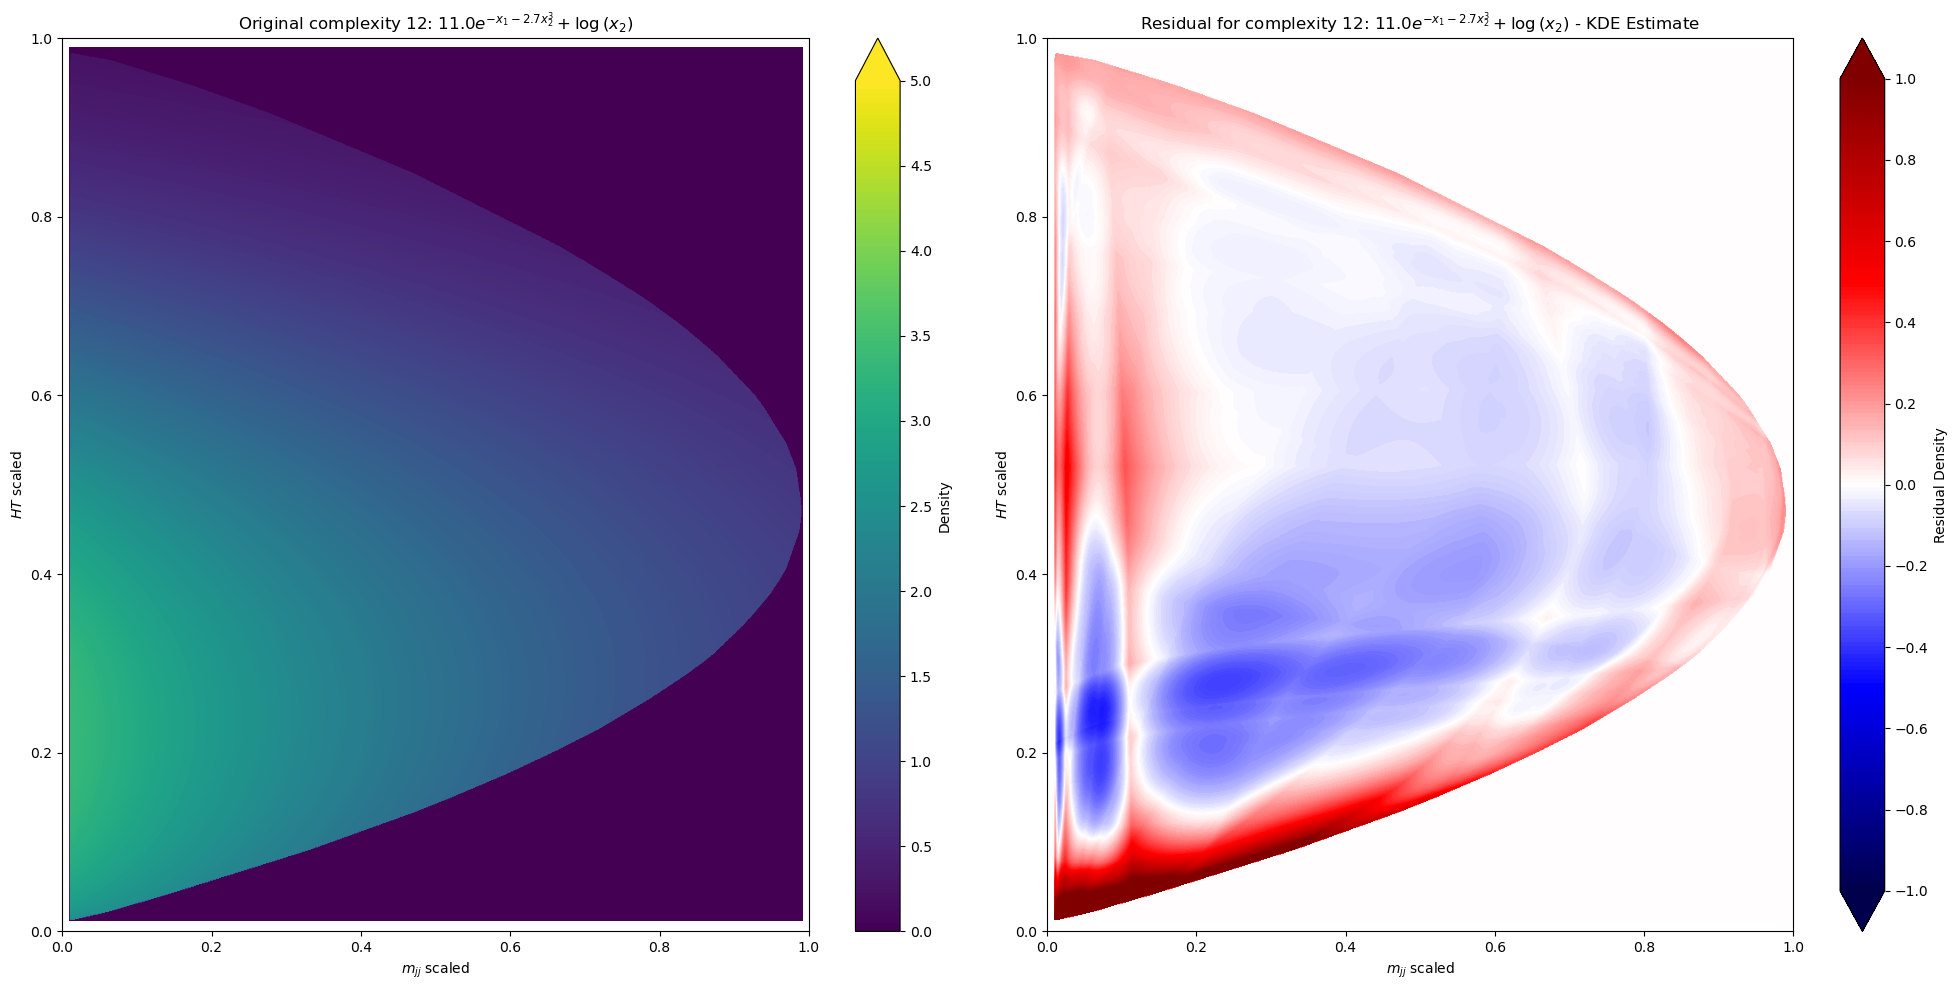

Complexity 12: Likelihood score: 27,132.43979133367
complexity 12 :: min predict: 0.00, max predict: 3.37
complexity 12 :: min residual: -0.45, max residual: 1.65
Complexity 12: MSE error: 1.836936e-01


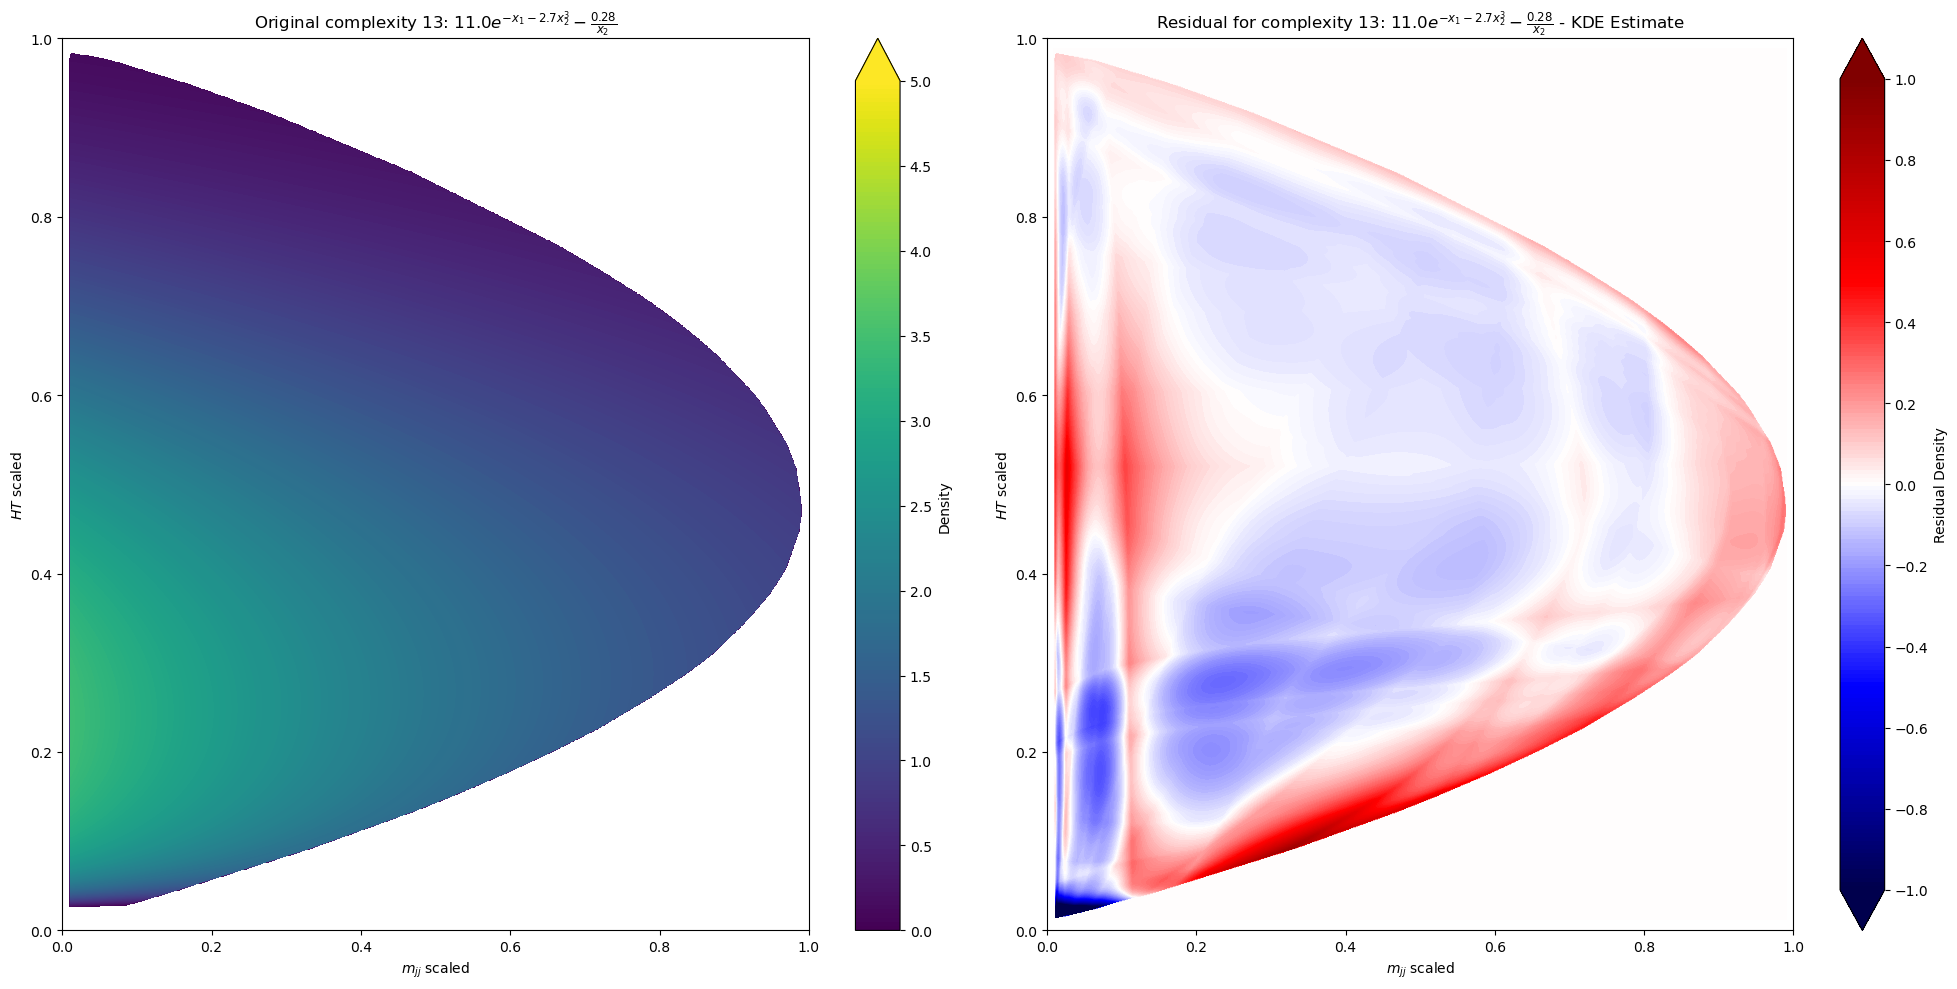

/tmp/ipykernel_169391/2856297620.py:74: RuntimeWarning:

invalid value encountered in log



Complexity 13: Likelihood score: nan
complexity 13 :: min predict: -3.58, max predict: 3.44
complexity 13 :: min residual: -4.47, max residual: 0.88
Complexity 13: MSE error: 1.048870e-01


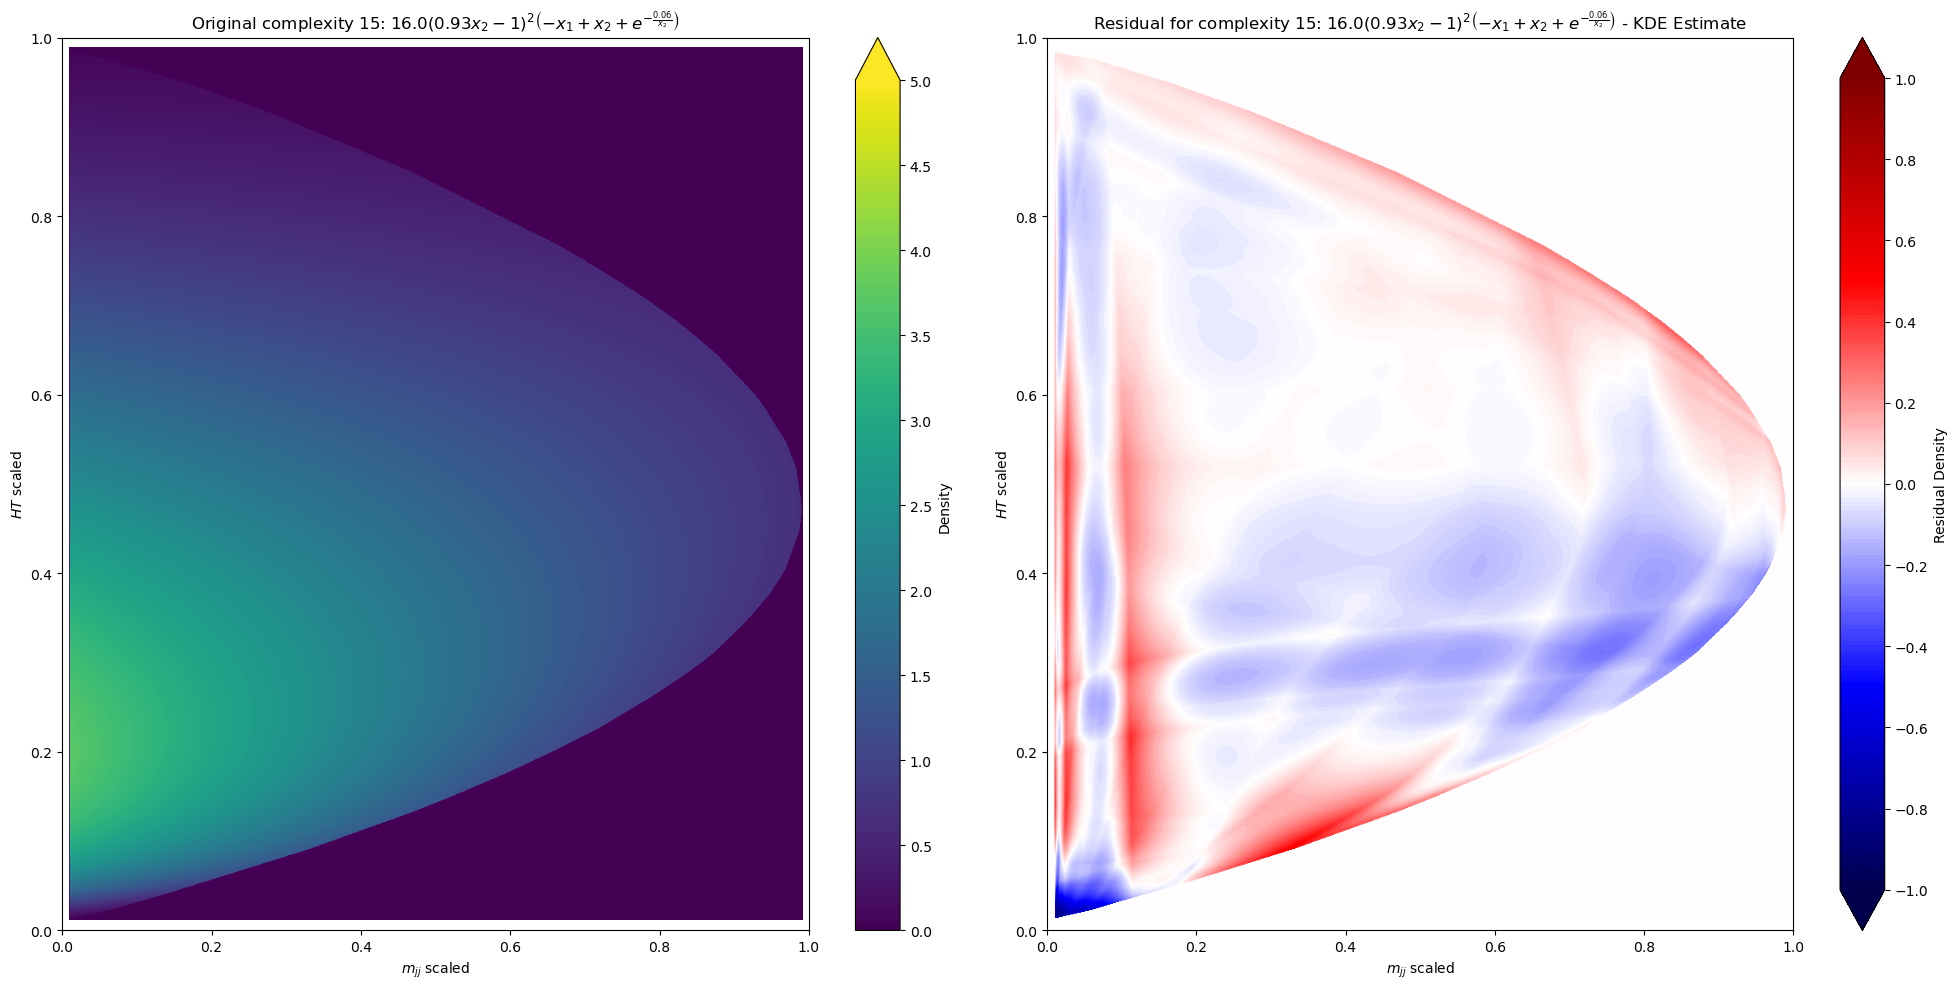

Complexity 15: Likelihood score: nan
complexity 15 :: min predict: 0.00, max predict: 3.69
complexity 15 :: min residual: -0.90, max residual: 0.51
Complexity 15: MSE error: 4.789141e-02


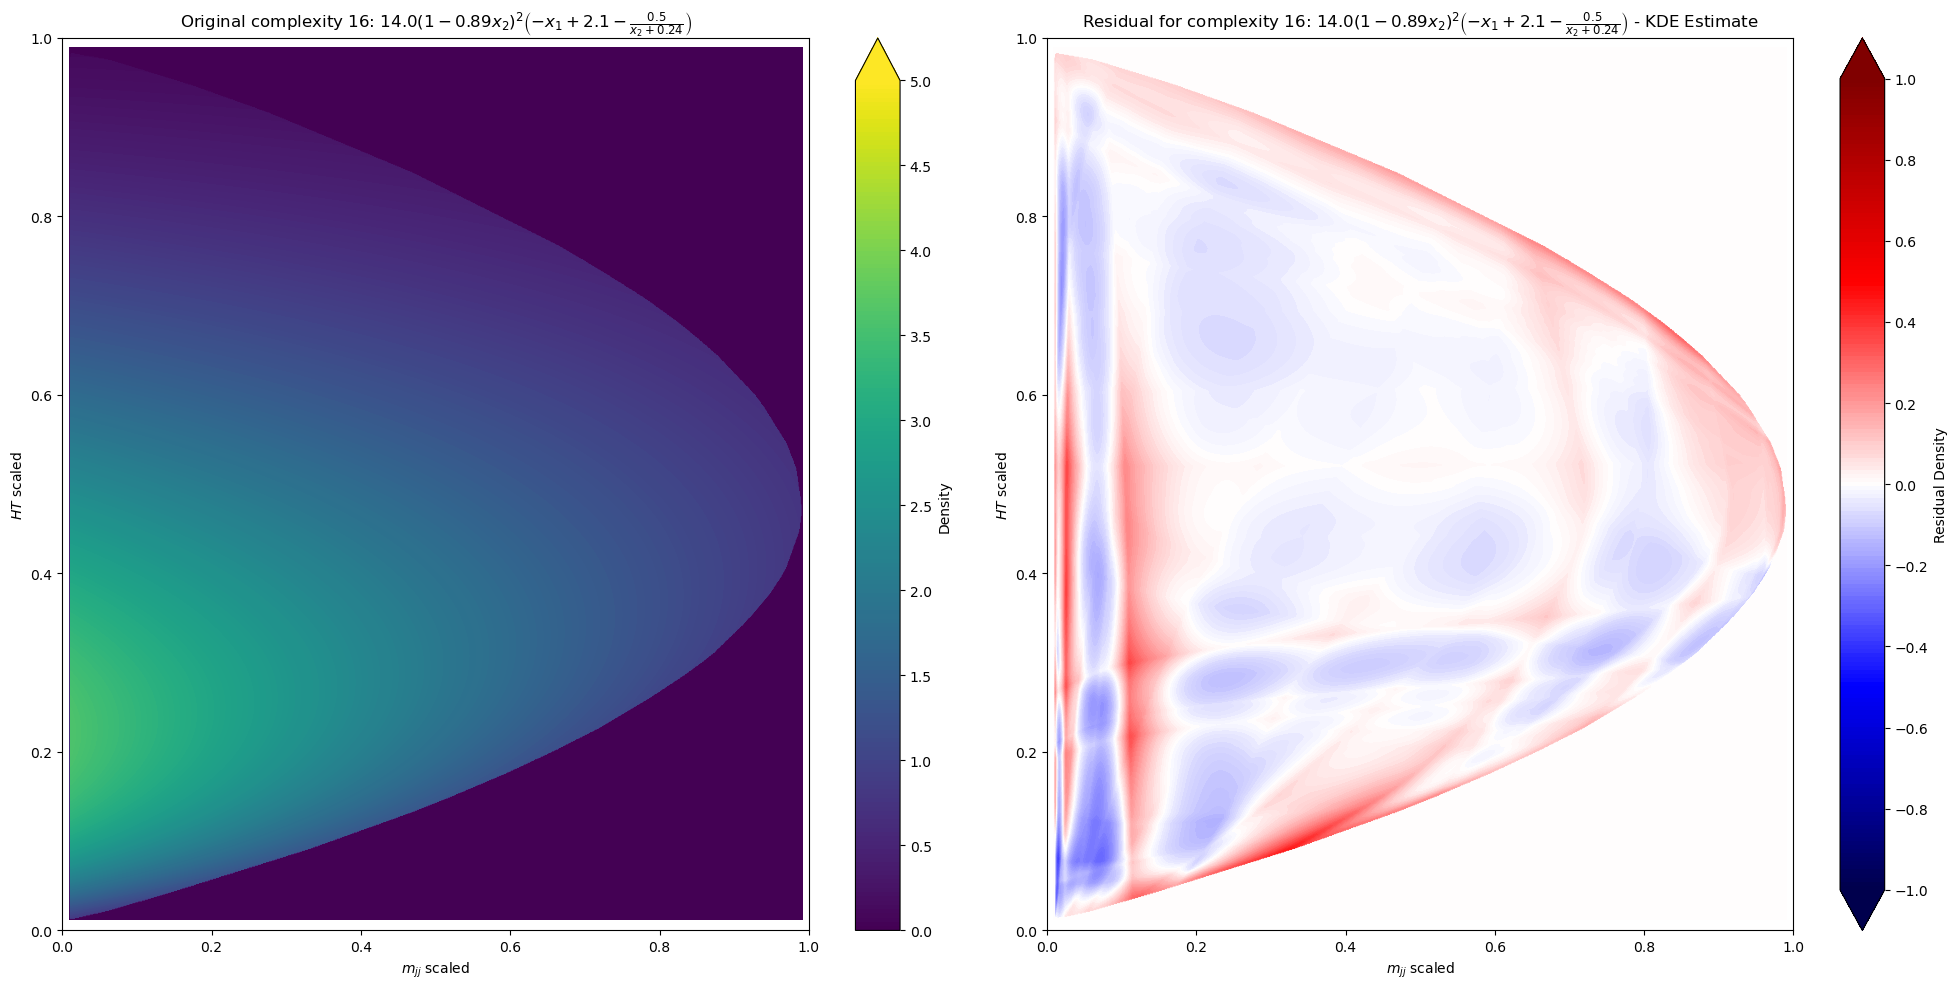

Complexity 16: Likelihood score: 27,325.864049816435
complexity 16 :: min predict: 0.00, max predict: 3.59
complexity 16 :: min residual: -0.39, max residual: 0.46
Complexity 16: MSE error: 2.663650e-02


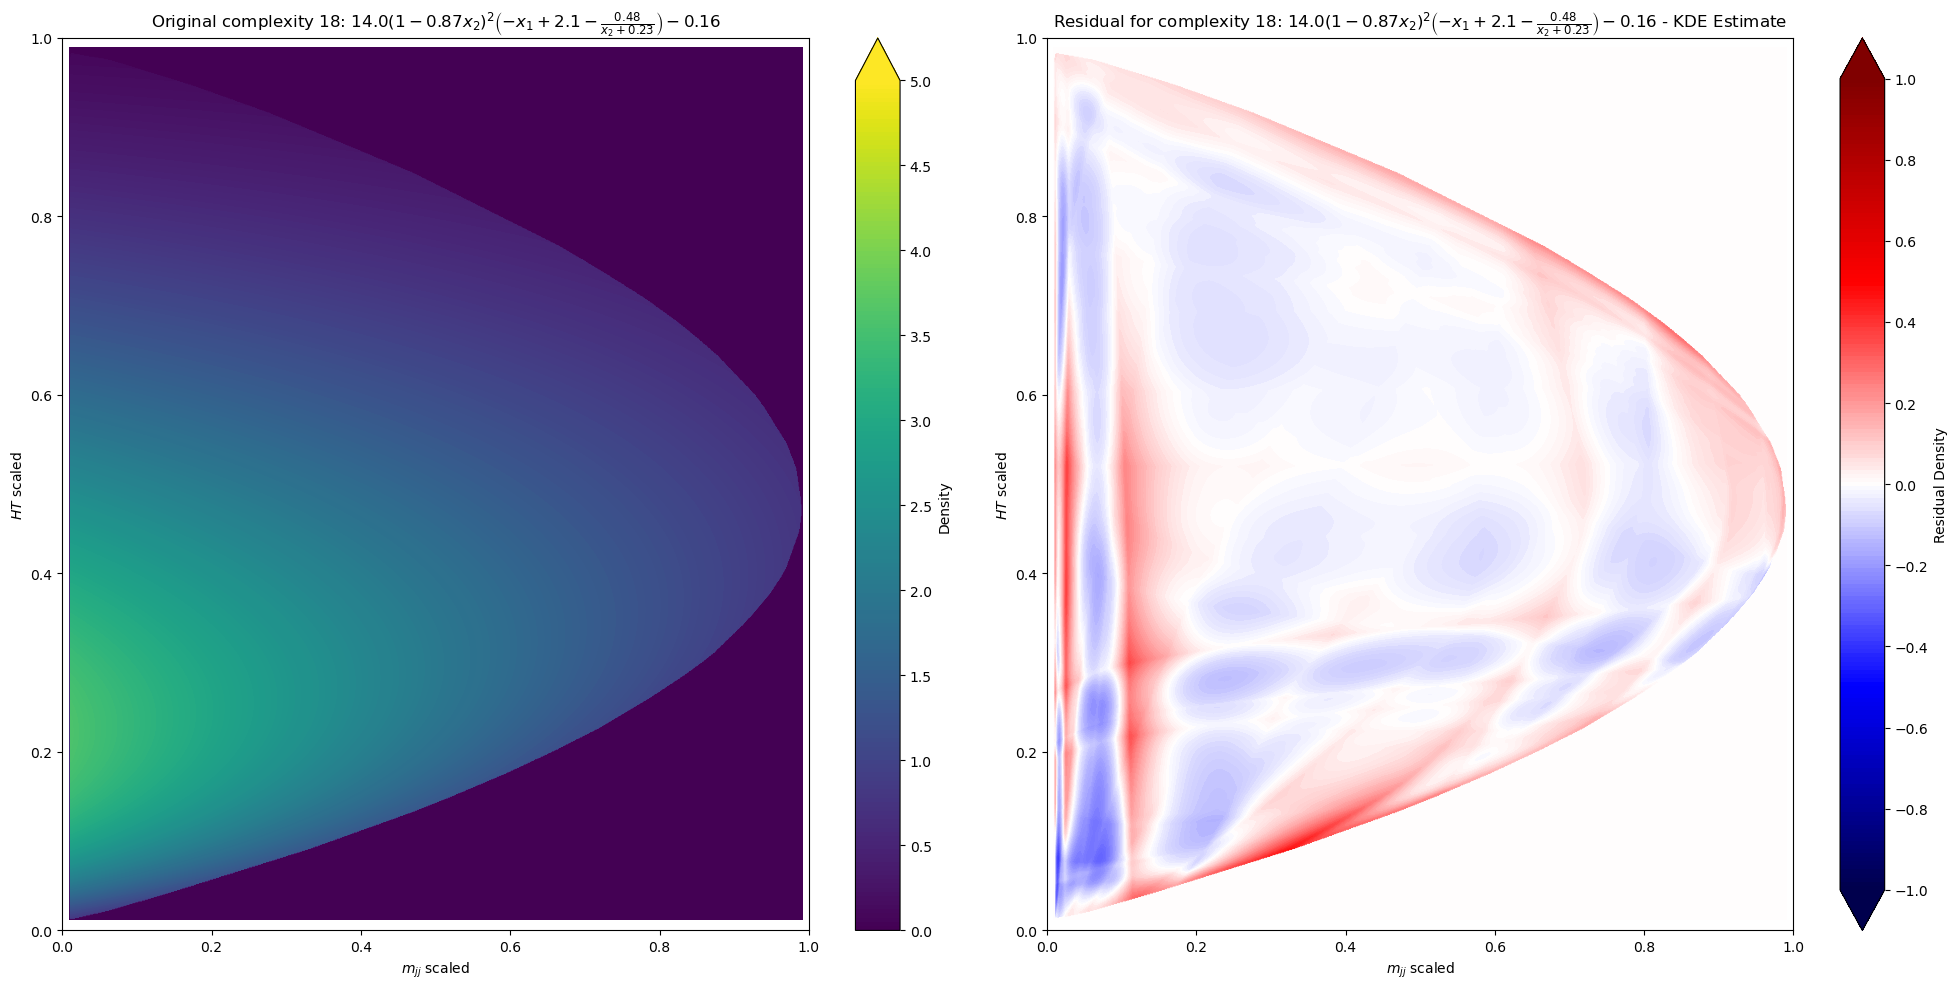

Complexity 18: Likelihood score: 27,312.849735591306
complexity 18 :: min predict: 0.00, max predict: 3.58
complexity 18 :: min residual: -0.40, max residual: 0.47
Complexity 18: MSE error: 2.652509e-02


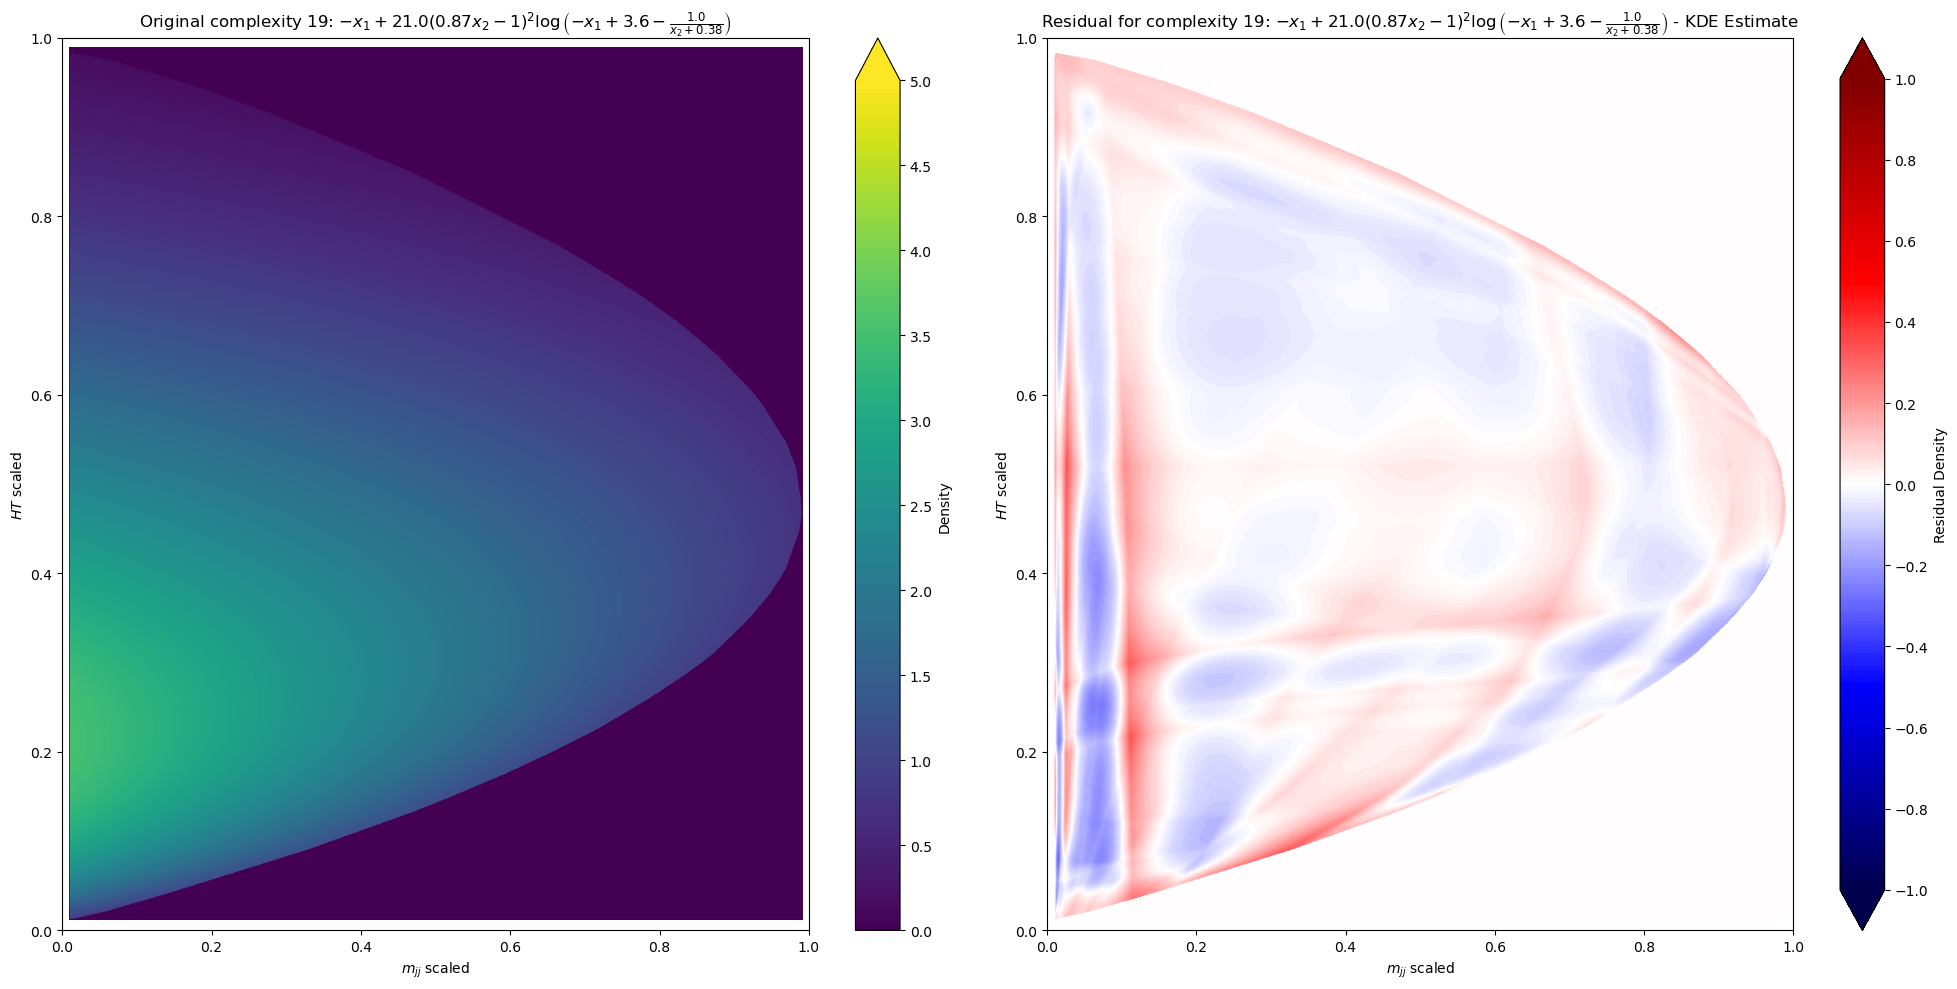

Complexity 19: Likelihood score: 27,267.848284750406
complexity 19 :: min predict: 0.00, max predict: 3.53
complexity 19 :: min residual: -0.31, max residual: 0.33
Complexity 19: MSE error: 2.016225e-02


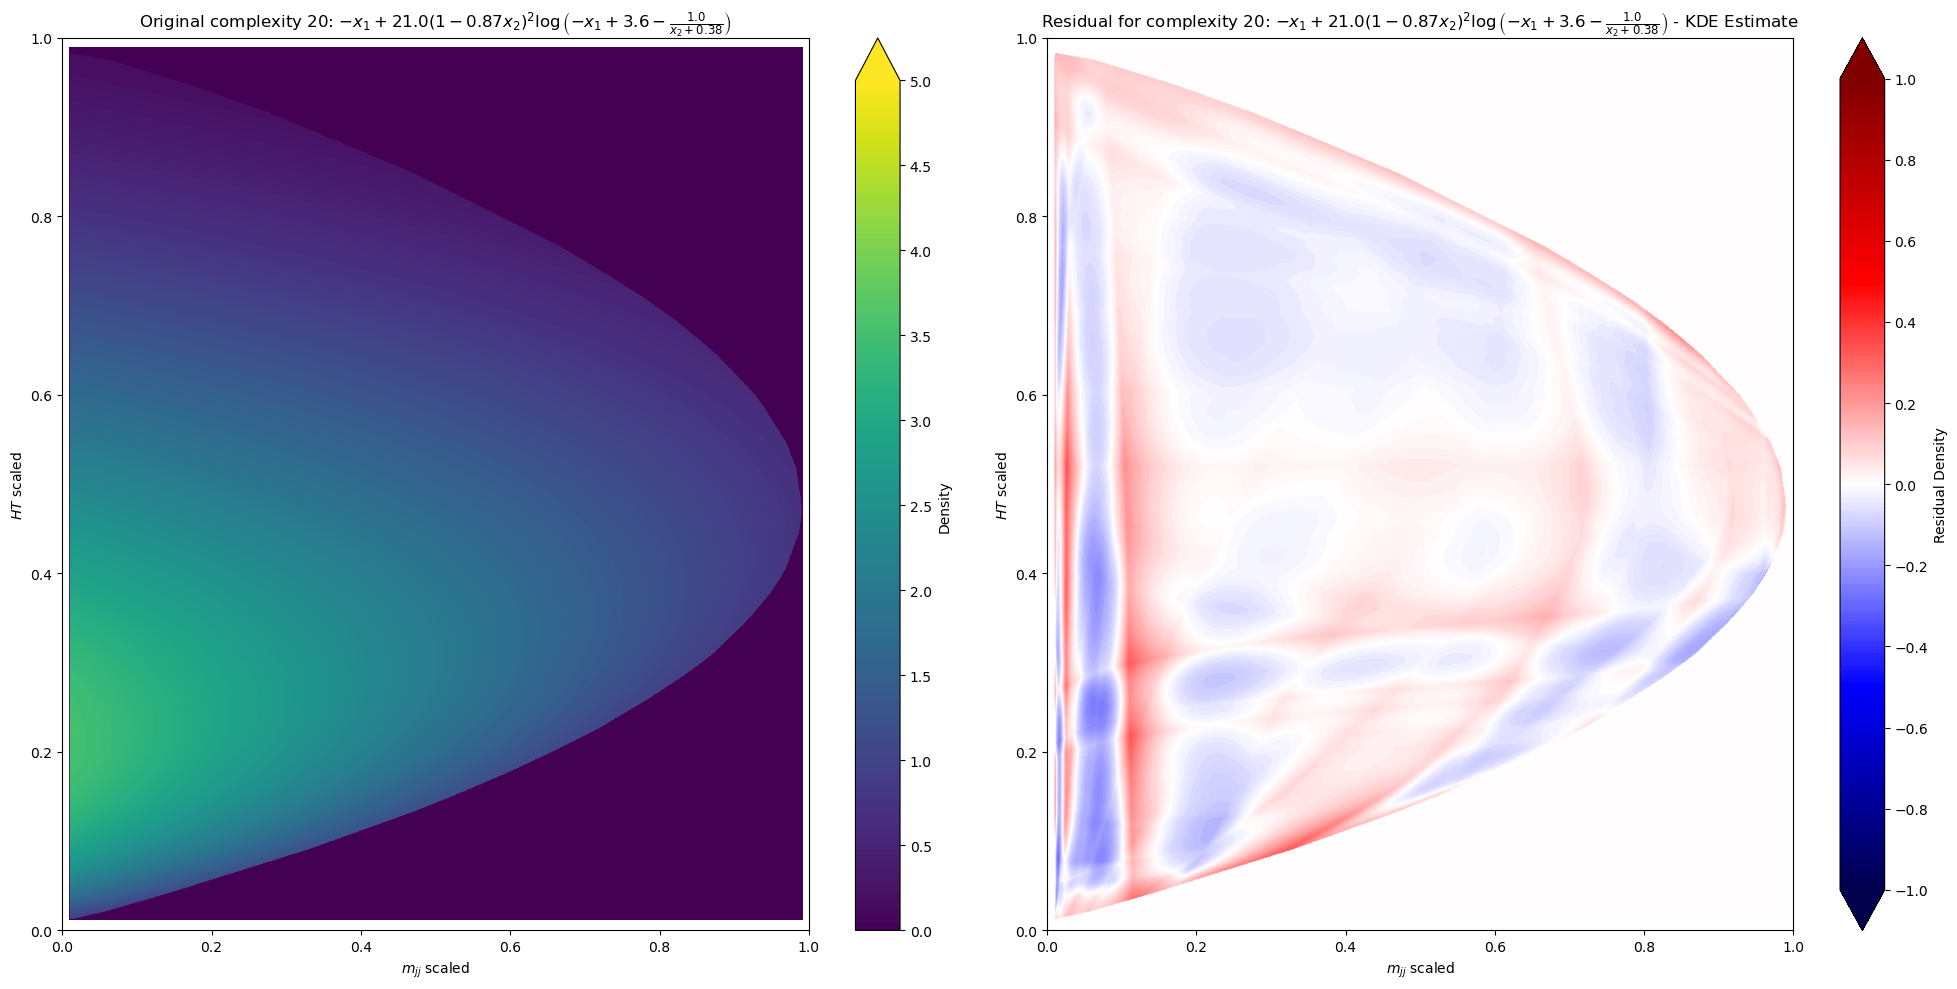

Complexity 20: Likelihood score: 27,276.29096103582
complexity 20 :: min predict: 0.00, max predict: 3.53
complexity 20 :: min residual: -0.31, max residual: 0.33
Complexity 20: MSE error: 2.016132e-02


<string>:1: RuntimeWarning:

invalid value encountered in log



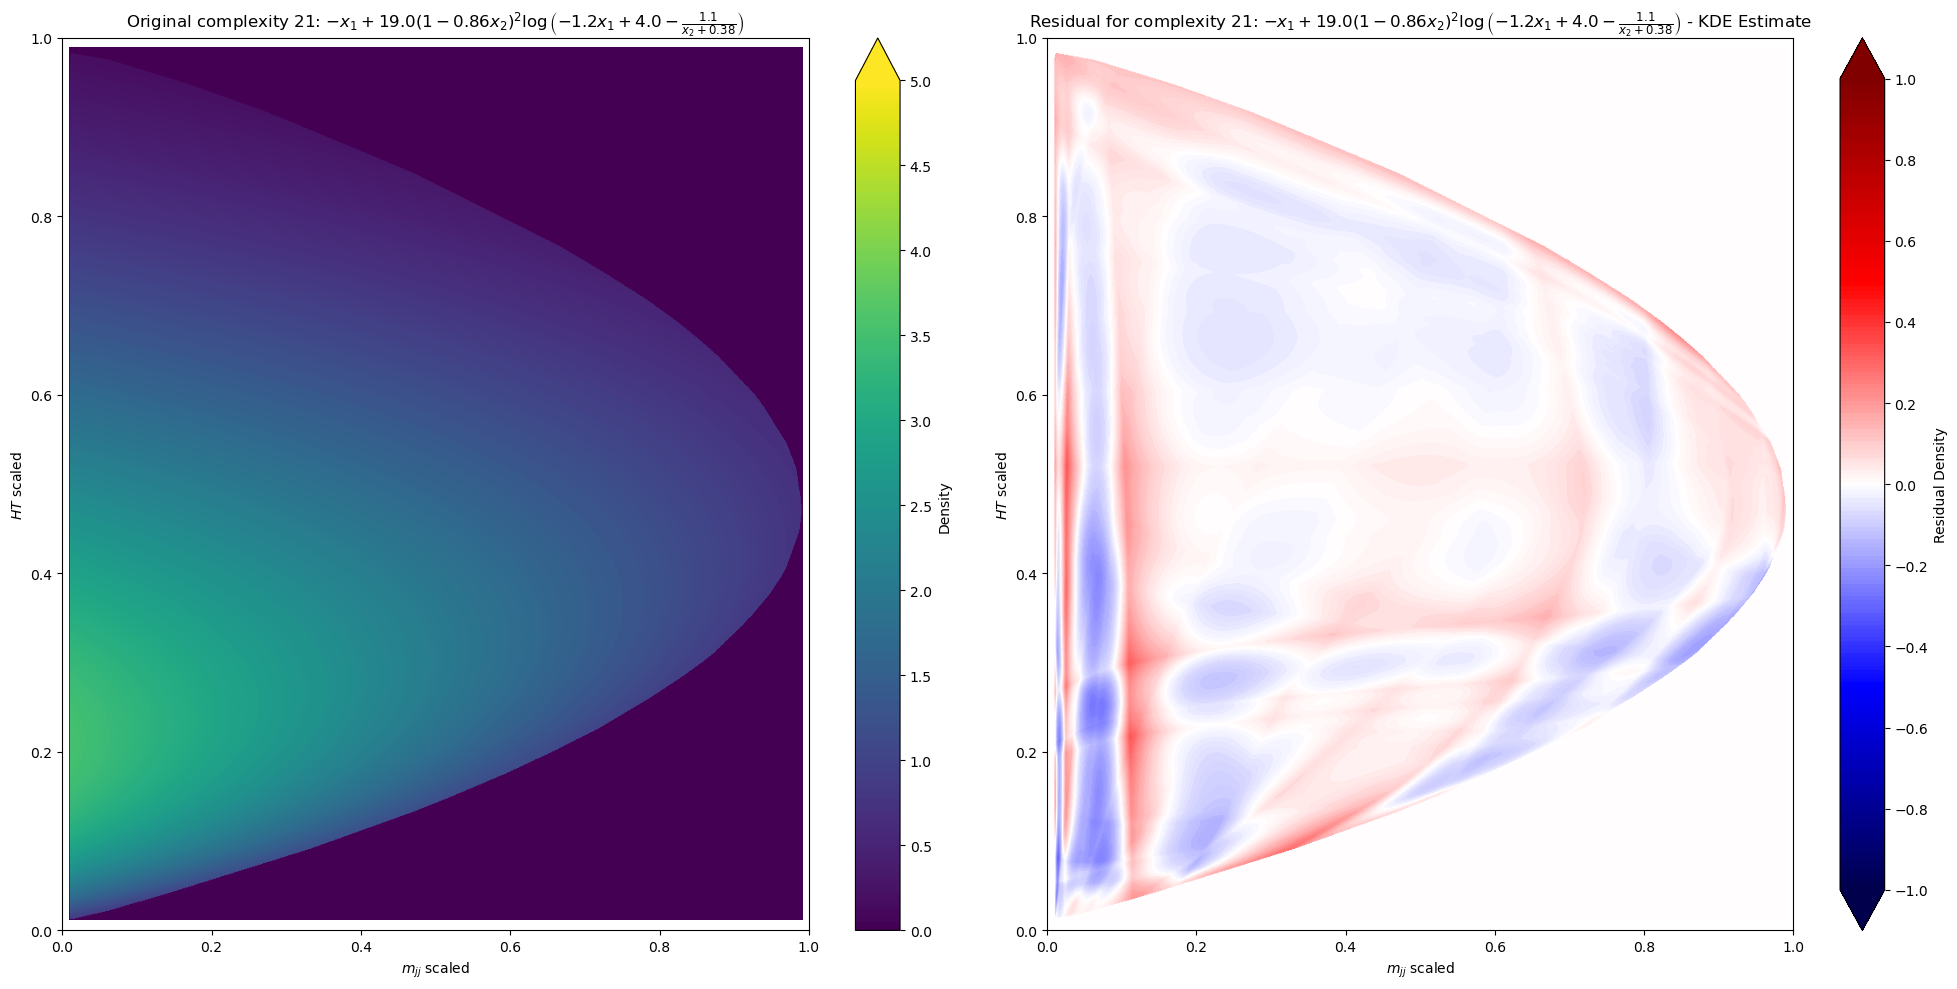

Complexity 21: Likelihood score: 27,293.122417873143
complexity 21 :: min predict: 0.00, max predict: 3.52
complexity 21 :: min residual: -0.32, max residual: 0.32
Complexity 21: MSE error: 2.003933e-02


<string>:1: RuntimeWarning:

invalid value encountered in log



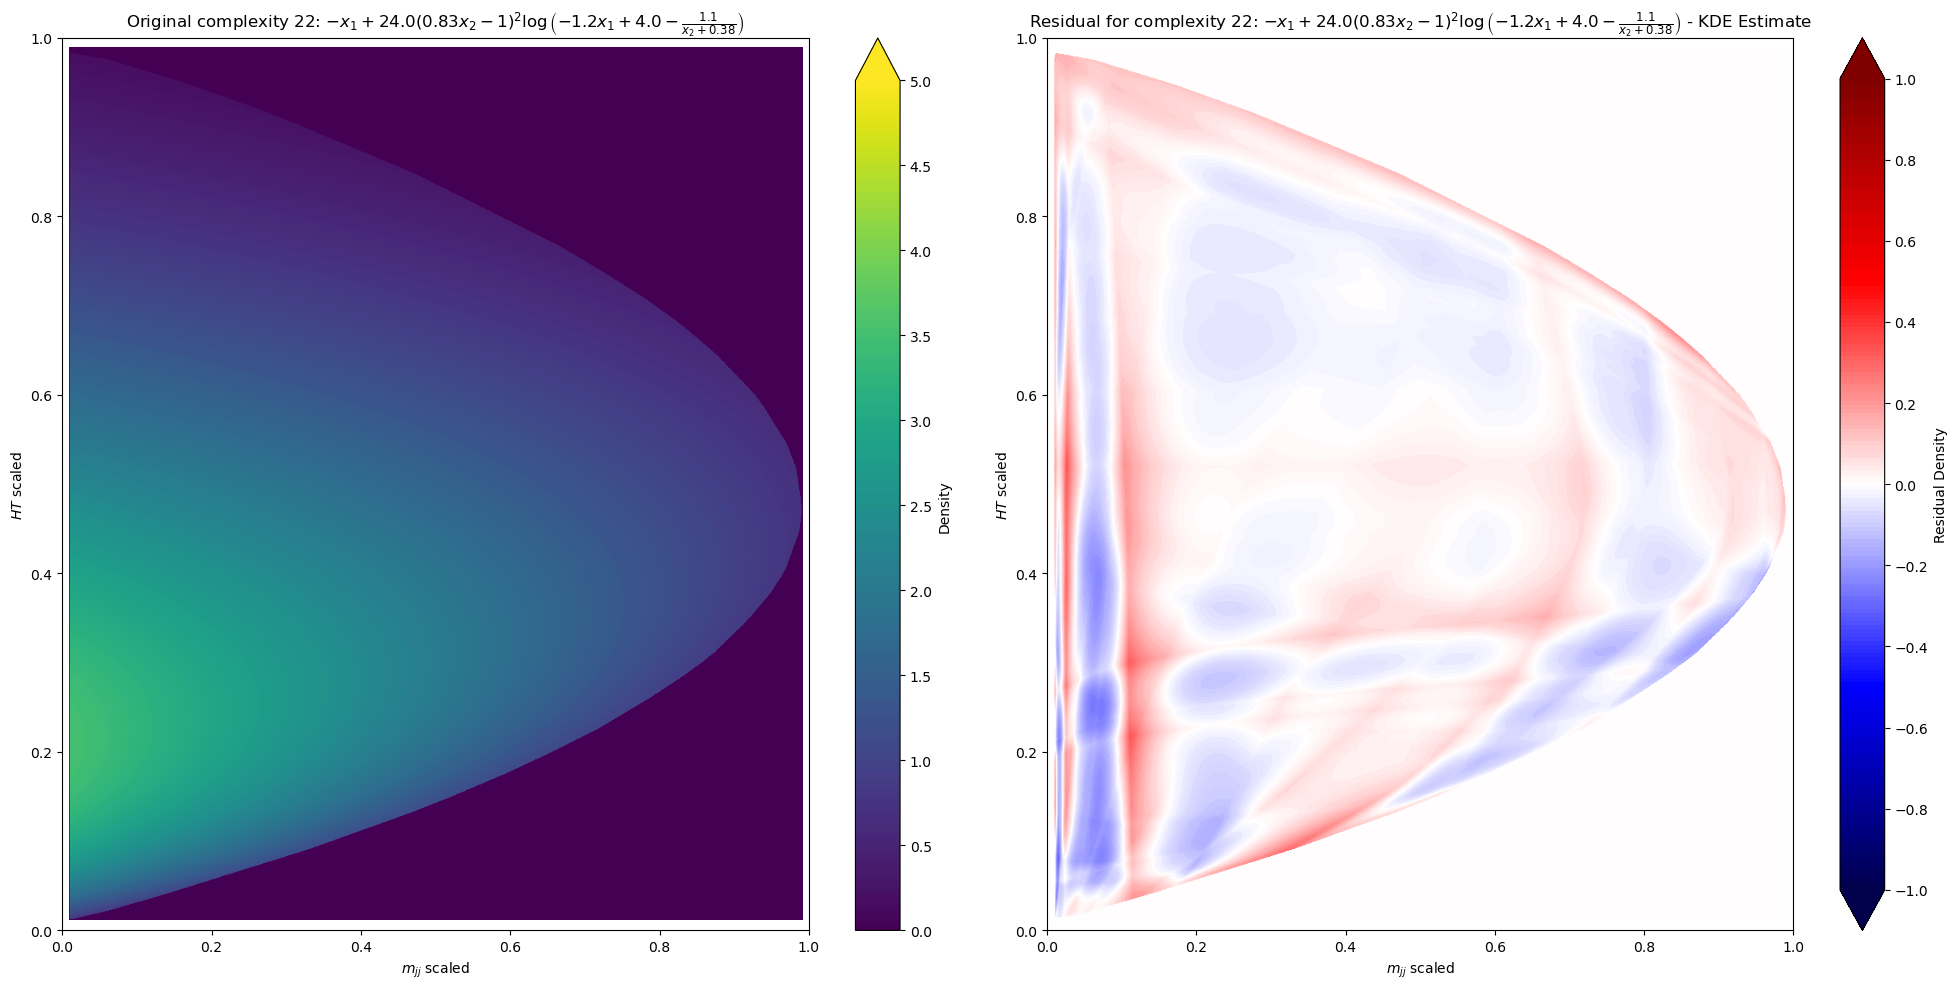

Complexity 22: Likelihood score: 27,305.221443201
complexity 22 :: min predict: 0.00, max predict: 3.52
complexity 22 :: min residual: -0.32, max residual: 0.32
Complexity 22: MSE error: 2.003443e-02


<string>:1: RuntimeWarning:

invalid value encountered in log



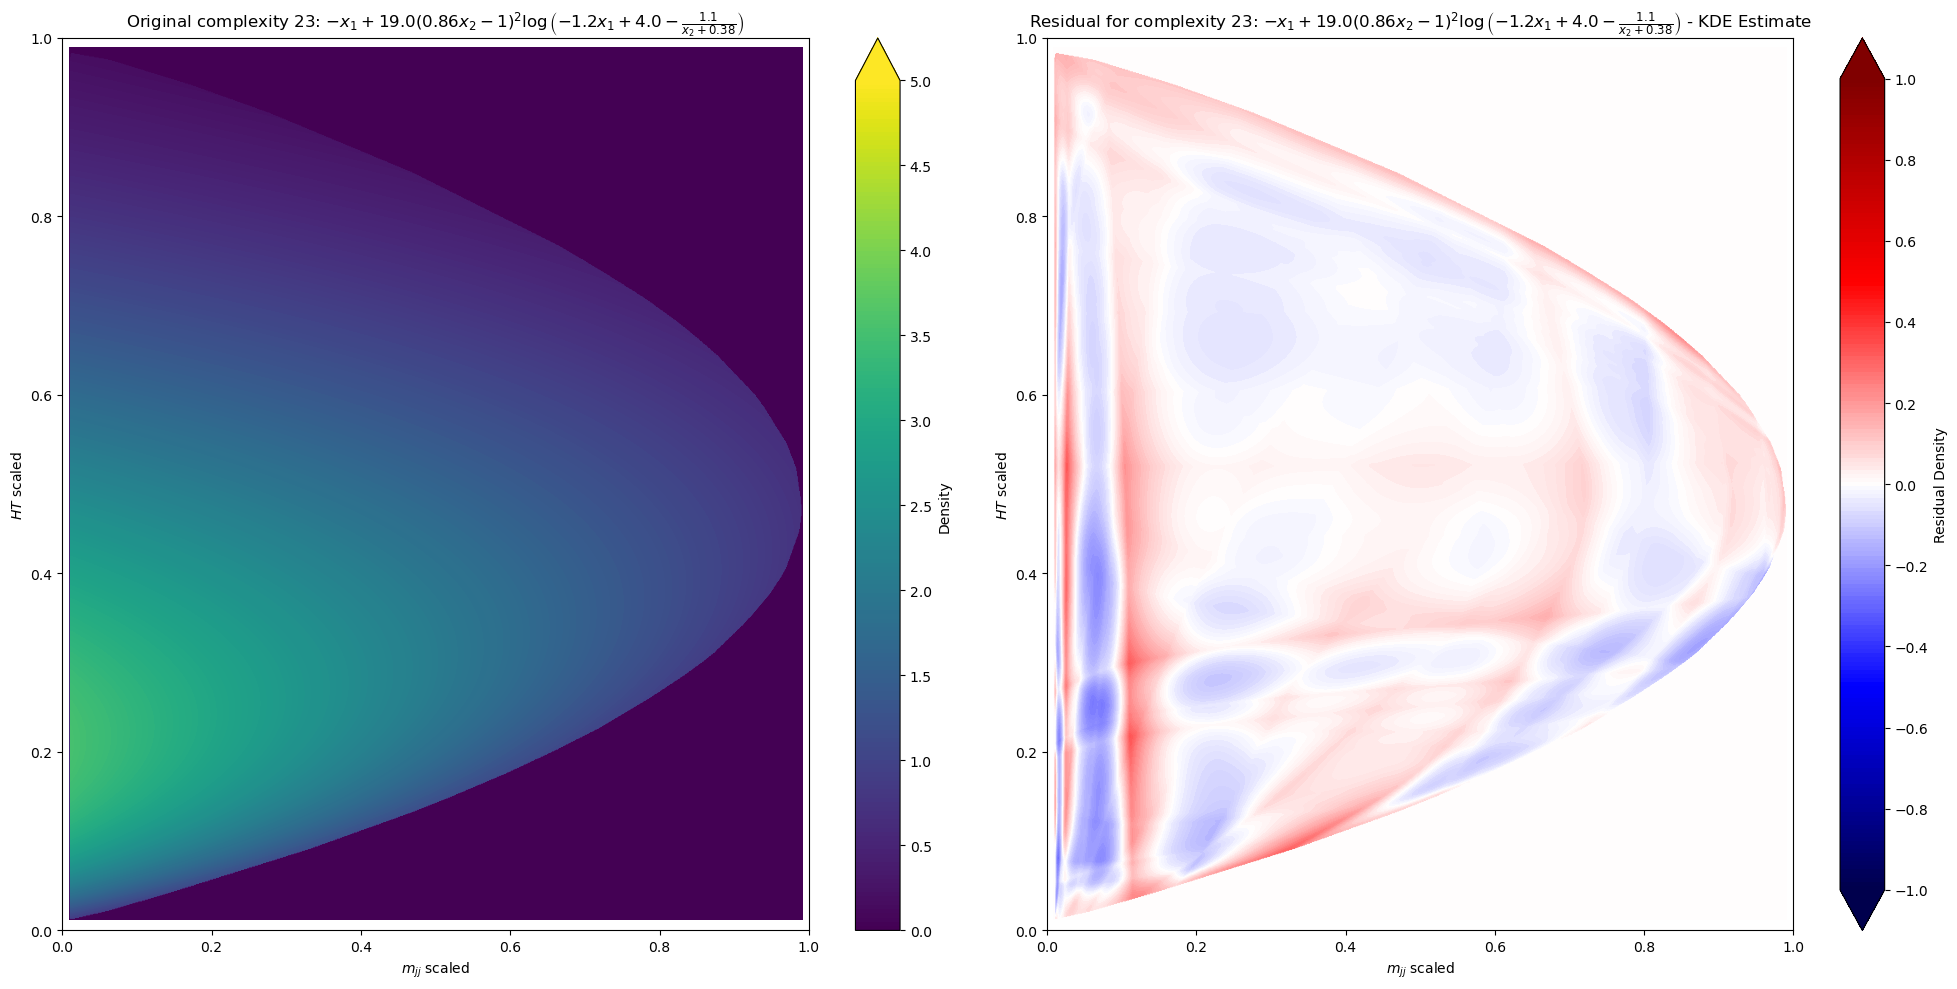

Complexity 23: Likelihood score: 27,400.7773026233
complexity 23 :: min predict: 0.00, max predict: 3.53
complexity 23 :: min residual: -0.30, max residual: 0.33
Complexity 23: MSE error: 1.995716e-02


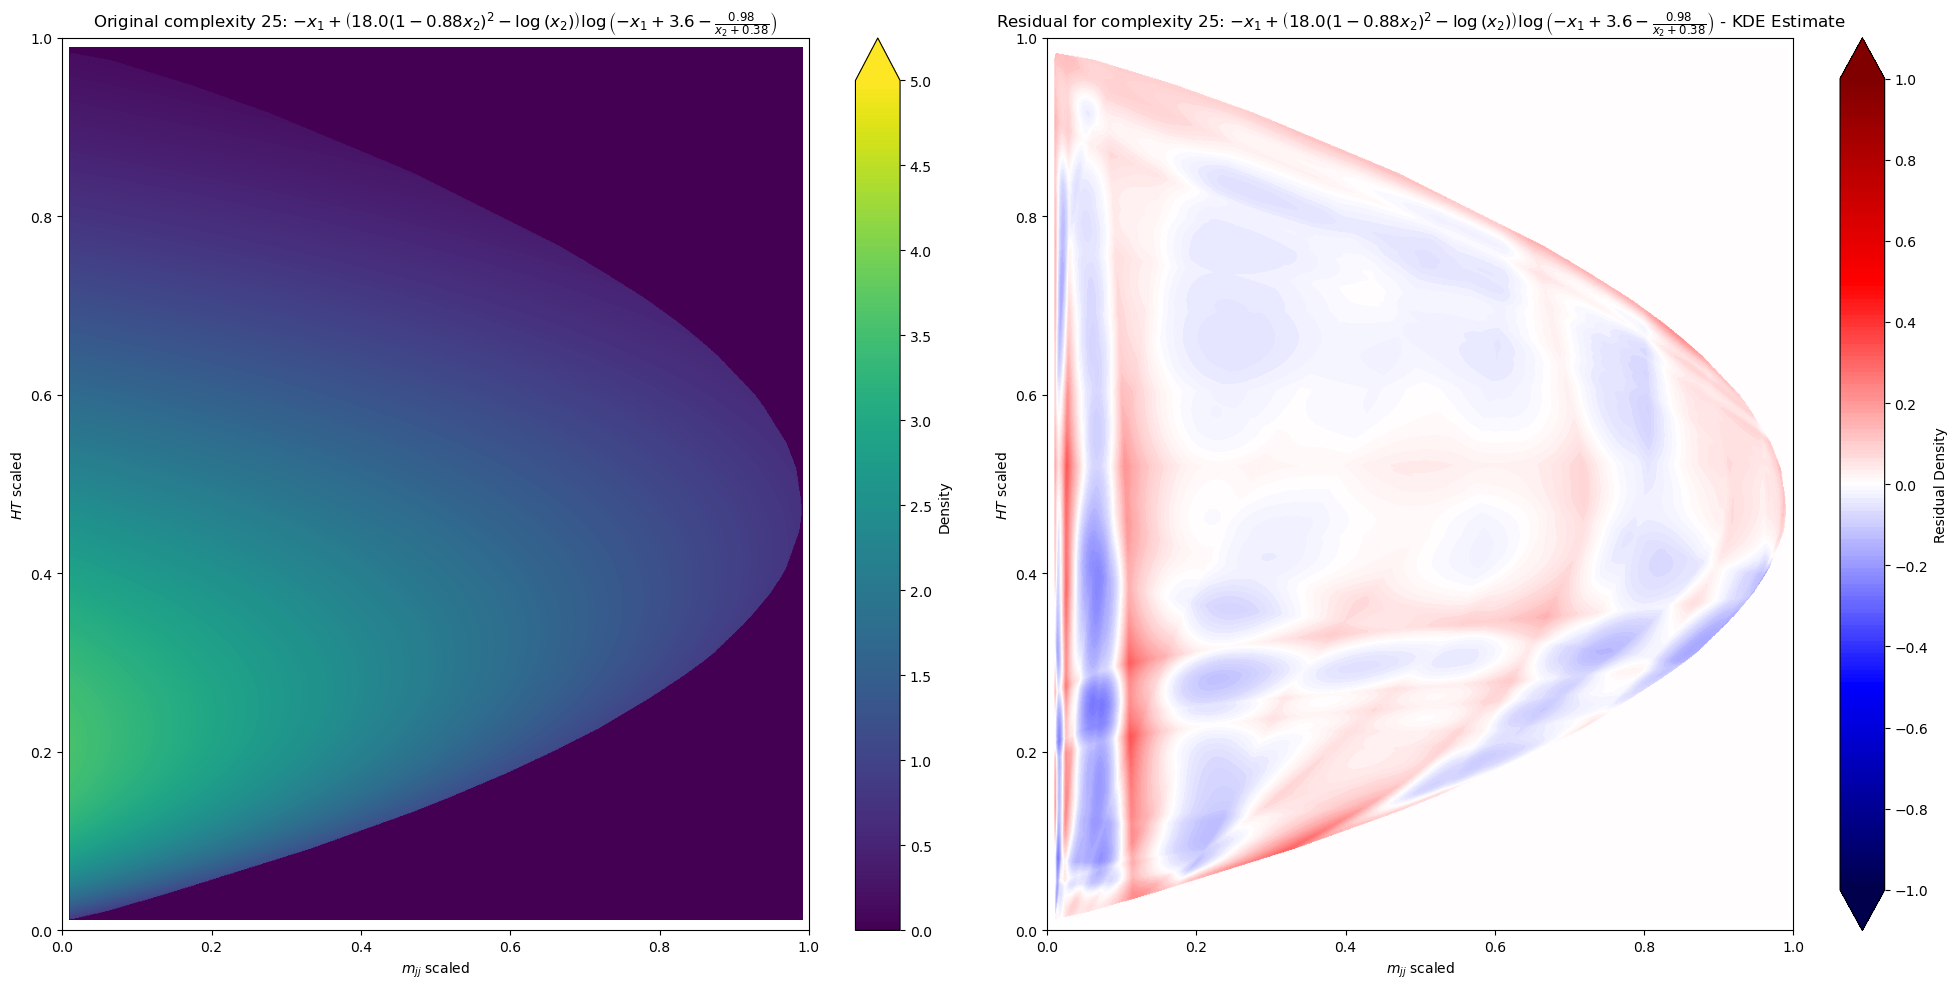

Complexity 25: Likelihood score: 27,287.155964402038
complexity 25 :: min predict: 0.00, max predict: 3.53
complexity 25 :: min residual: -0.27, max residual: 0.33
Complexity 25: MSE error: 1.920530e-02


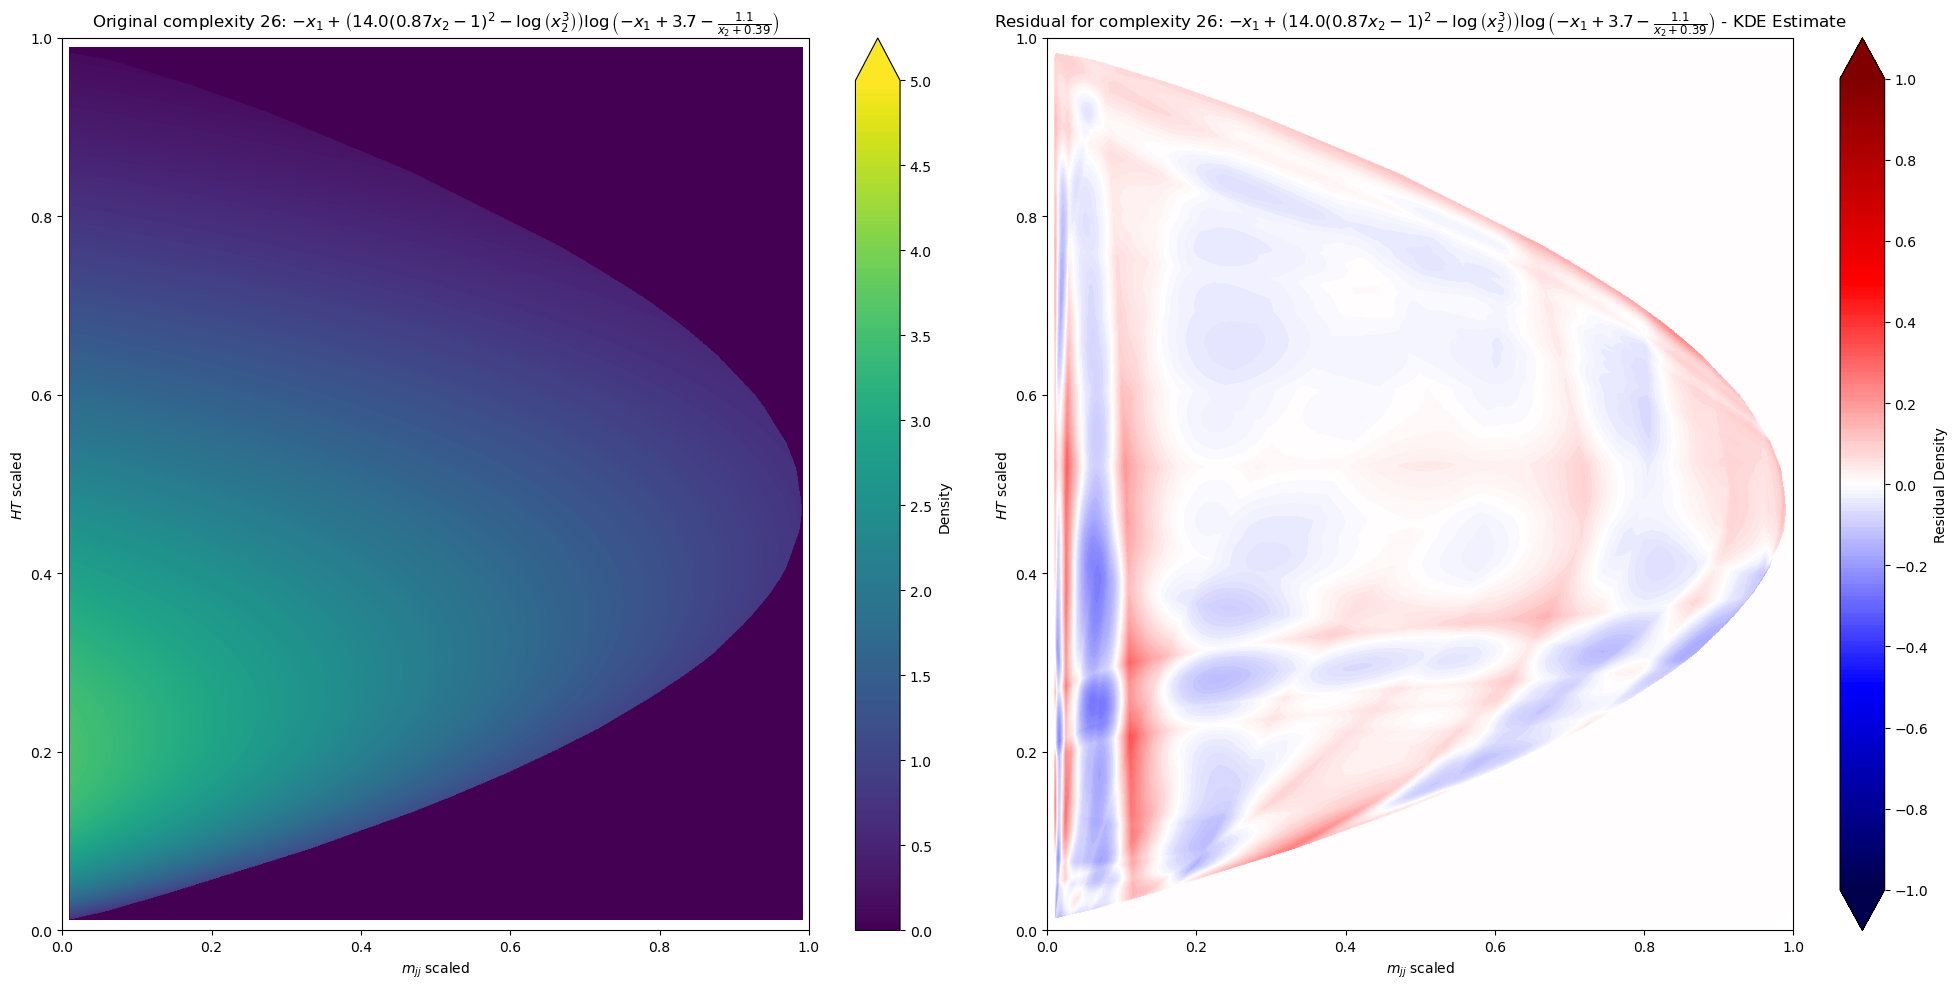

Complexity 26: Likelihood score: 27,240.905065075625
complexity 26 :: min predict: 0.00, max predict: 3.55
complexity 26 :: min residual: -0.27, max residual: 0.33
Complexity 26: MSE error: 1.829558e-02


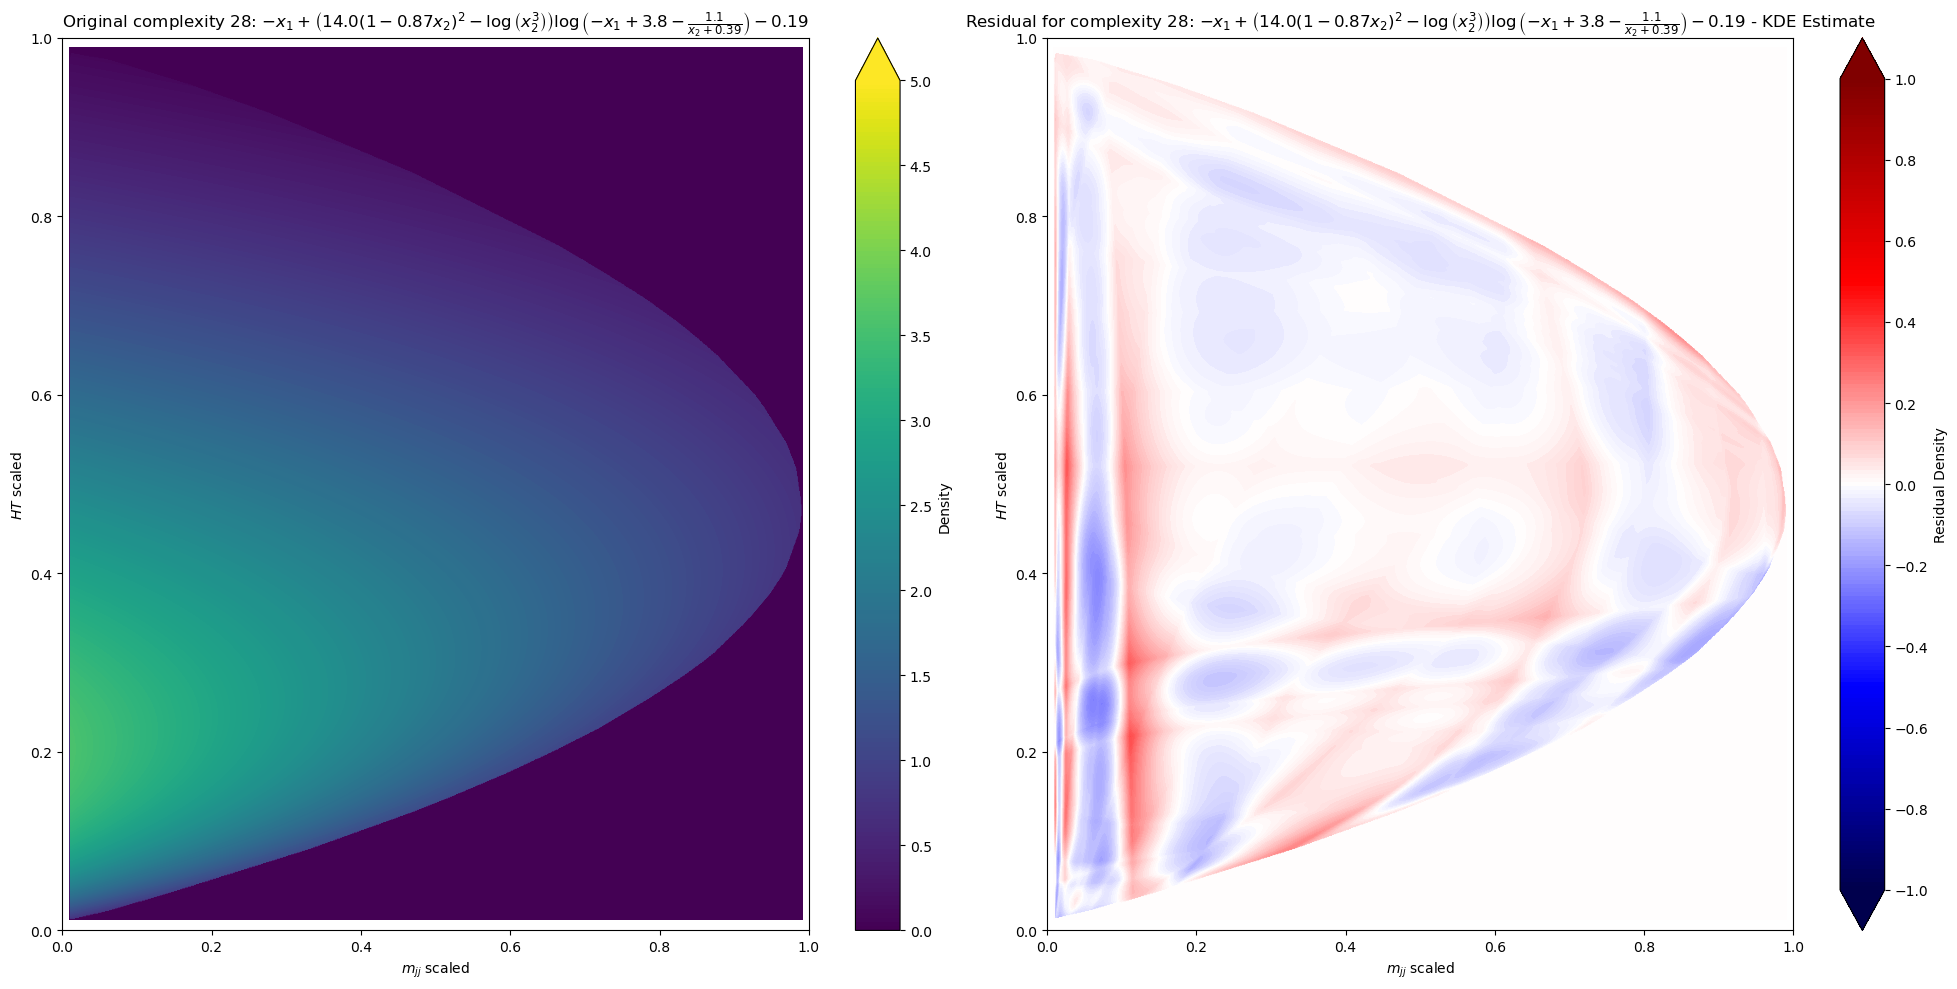

Complexity 28: Likelihood score: 27,275.457033715036
complexity 28 :: min predict: 0.00, max predict: 3.56
complexity 28 :: min residual: -0.25, max residual: 0.35
Complexity 28: MSE error: 1.828672e-02


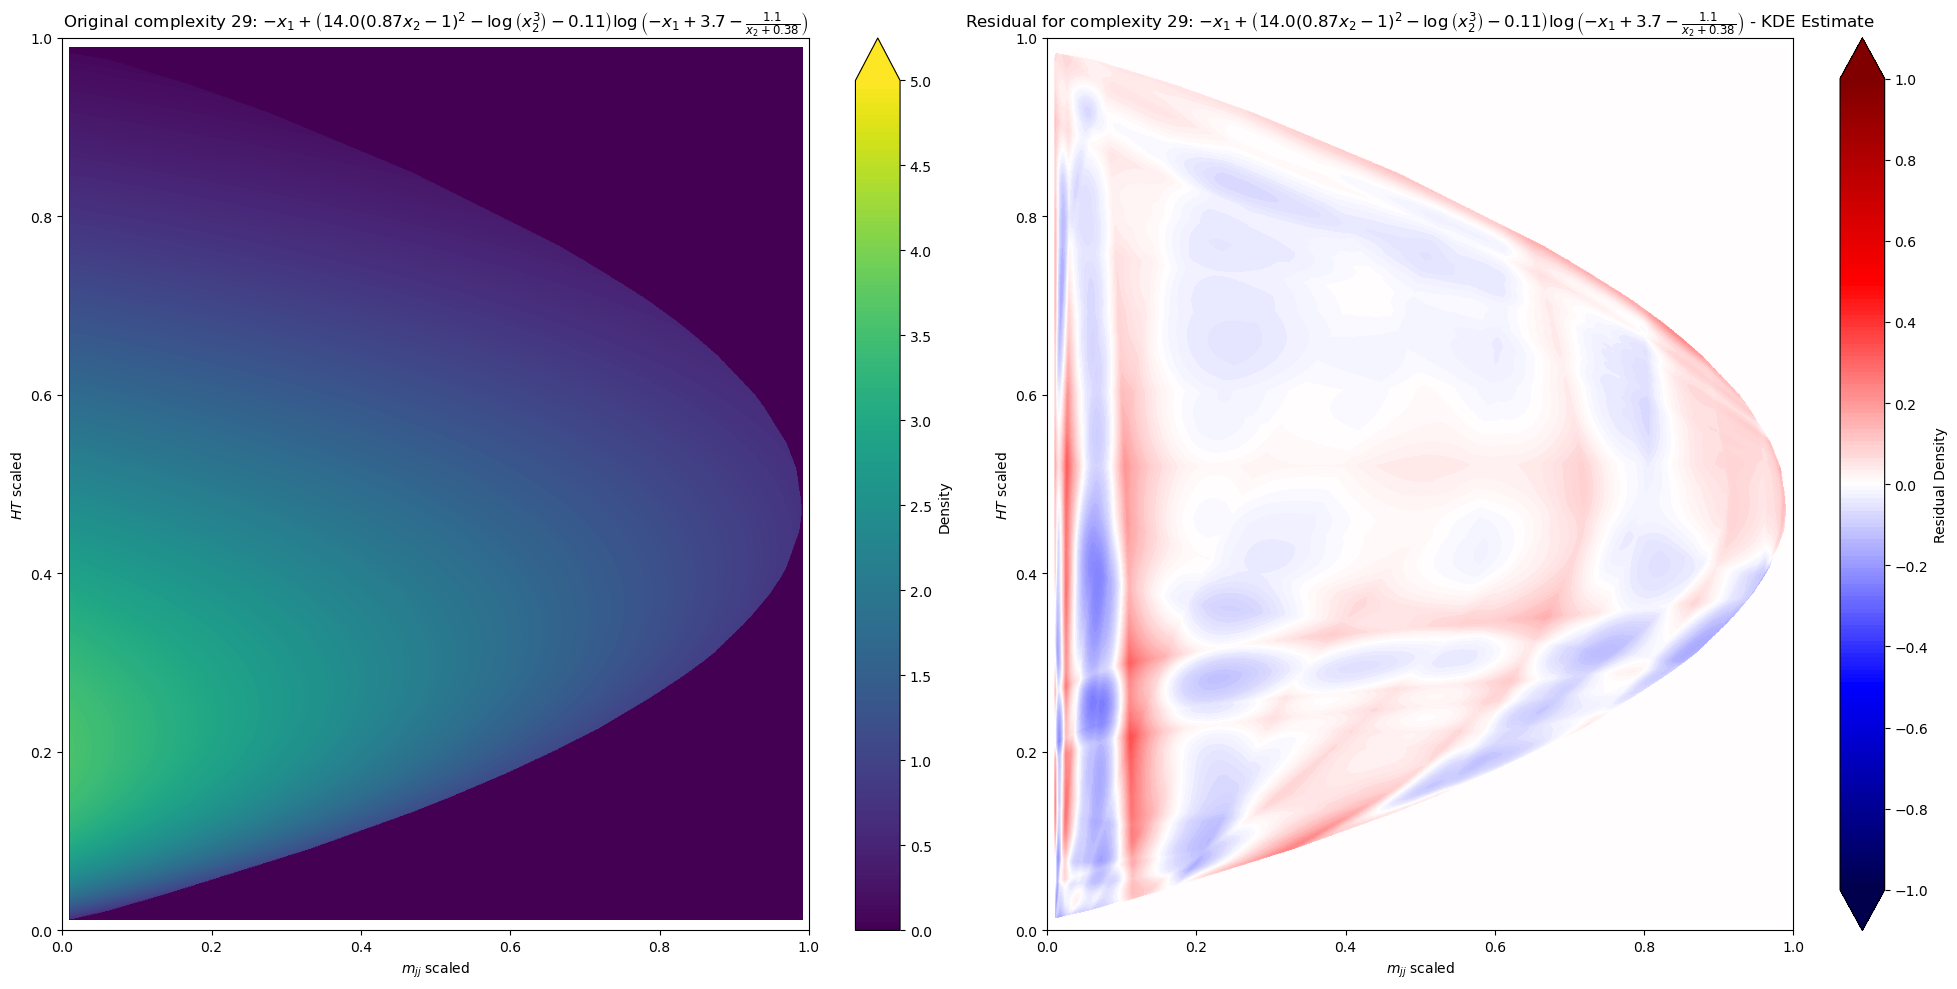

Complexity 29: Likelihood score: 27,284.77176392725
complexity 29 :: min predict: 0.00, max predict: 3.56
complexity 29 :: min residual: -0.26, max residual: 0.34
Complexity 29: MSE error: 1.821789e-02
Finished generating and saving plots for 24 functions.


In [115]:
# Iterate over the masked_functions list
for i, current_function in enumerate(masked_functions):
    # Skip if the function is not defined or you only want to plot specific ones
    # if i not in [2, 5]:  # Example: plot only indices 2 and 5
    #     continue

    # Get the title for the current function
    title = latex_labels[i]

    # Create a new figure for each iteration
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # --- Plot 1: Original Function Plot (current_function) ---
    ax1 = axes[0]
    
    # Calculate the function output
    function_output = current_function(grids[0], grids[1], mask)
    if np.shape(function_output) == (1,1) or np.shape(function_output)==():
        function_output = function_output*np.ones(grids[0].shape)

    # Set levels based on your required range
    levels_original = np.linspace(level_min, level_max, 200)
    
    contour1 = ax1.contourf(
        grids[0], grids[1],
        function_output/density_scale_factor,
        levels=levels_original,
        cmap='viridis',
        extend='max'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour1, ax=ax1, label="Density", ticks=np.linspace(level_min, level_max, 11))
    
    ax1.set_xlabel(r"$m_{jj}$ scaled")
    ax1.set_ylabel(r"$HT$ scaled")
    ax1.set_title(f"Original complexity {complexity[i]}: {title}")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    # --- Plot 2: Residual Plot (current_function - sum_grid) ---
    ax2 = axes[1]
    
    # Calculate the residual
    residual_output = function_output/density_scale_factor - neural_predicted_density
    residual_output[mask] = 0.0
    
    # Set levels for the residual plot (should be symmetric around zero)
    levels_residual = np.linspace(level_min_delta, level_max_delta, 200)
    
    contour2 = ax2.contourf(
        grids[0], grids[1],
        residual_output,
        levels=levels_residual,
        cmap='seismic', # 'seismic' is good for residuals (zero in the middle)
        extend='both'
    )
    # The colorbar needs to be updated for each plot
    fig.colorbar(contour2, ax=ax2, label="Residual Density", ticks=np.linspace(level_min_delta, level_max_delta, 11))
    
    ax2.set_xlabel(r"$m_{jj}$ scaled")
    ax2.set_ylabel(r"$HT$ scaled")
    ax2.set_title(f"Residual for complexity {complexity[i]}: {title} - KDE Estimate")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)

    # Final adjustments and saving
    plt.tight_layout()
    plt.show()
    plt.close(fig) 
    
    # 3. Force the Python garbage collector to clean up memory
    gc.collect()
    prediction_eval_at_samples = current_function(test_samples[:,0], test_samples[:,1], np.zeros(np.shape(test_samples[:,0])))
    likelihood_score_of_prediction = np.sum(np.log(prediction_eval_at_samples/density_scale_factor))
    print(f"Complexity {complexity[i]}: Likelihood score: {likelihood_score_of_prediction:,}")
    print(f"complexity {complexity[i]} :: min predict: {np.min(current_function(grids[0], grids[1], mask)/density_scale_factor):.2f}, max predict: {np.max(current_function(grids[0], grids[1], mask)/density_scale_factor):.2f}")
    min_residual = np.min(residual_output)
    max_residual = np.max(residual_output)
    print(f"complexity {complexity[i]} :: min residual: {min_residual:.2f}, max residual: {max_residual:.2f}")
    mse_error = np.mean((density_scale_factor*residual_output)**2)
    print(f"Complexity {complexity[i]}: MSE error: {mse_error:.6e}")
    # Explicitly delete large arrays and clear memory before the next loop iteration
    del prediction_eval_at_samples
    del residual_output
    gc.collect()


# Note: plt.show() is typically outside the loop if you want to see all plots
# or not used at all if you are just saving the files.
print(f"Finished generating and saving plots for {len(predicted_functions)} functions.")

# Other Views (Miscellaneous)

## Scatter plot of data input to SR pipeline

In [116]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

data_original = np.loadtxt('data/processed_data/muon_decay_joint_data.csv', delimiter=',', skiprows=1)
indices = np.random.choice(data_original.shape[0], size=1000, replace=False)
data = data_original[indices]
fig = go.Figure(data=[go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    )
)])

# fig.show(renderer='browser')
pio.show(fig)

## Joint data in pipeline

In [117]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

data_in_pipeline = np.loadtxt('data/processed_data/muon_decay_joint_data_in_pipeline.csv', delimiter=',', skiprows=1)
indices = np.random.choice(data_in_pipeline.shape[0], size=1000, replace=False)
data = data_in_pipeline[indices]
fig = go.Figure(data=[go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color='red',
        opacity=0.8
    )
)])

# fig.show(renderer='browser')
pio.show(fig)